Current system is macOS
9
[array([ 8,  9, 19, 20]), array([ 0,  1, 10, 11]), array([ 6,  7, 16, 17, 18, 27, 28]), array([ 2,  3, 12, 13, 14, 23, 24]), array([21, 22, 31, 32, 42, 43]), array([29, 30, 40, 41, 50, 51]), array([33, 34, 44, 45]), array([38, 39, 48, 49]), array([ 4,  5, 15, 25, 26, 35, 36, 37, 46, 47])]
HbO: (64, 1250, 9)


/var/folders/dj/c5r3qbs52hg_qgrqgmmp61_m0000gn/T/ipykernel_26305/338194668.py:115: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 5, figsize=(20, 6))


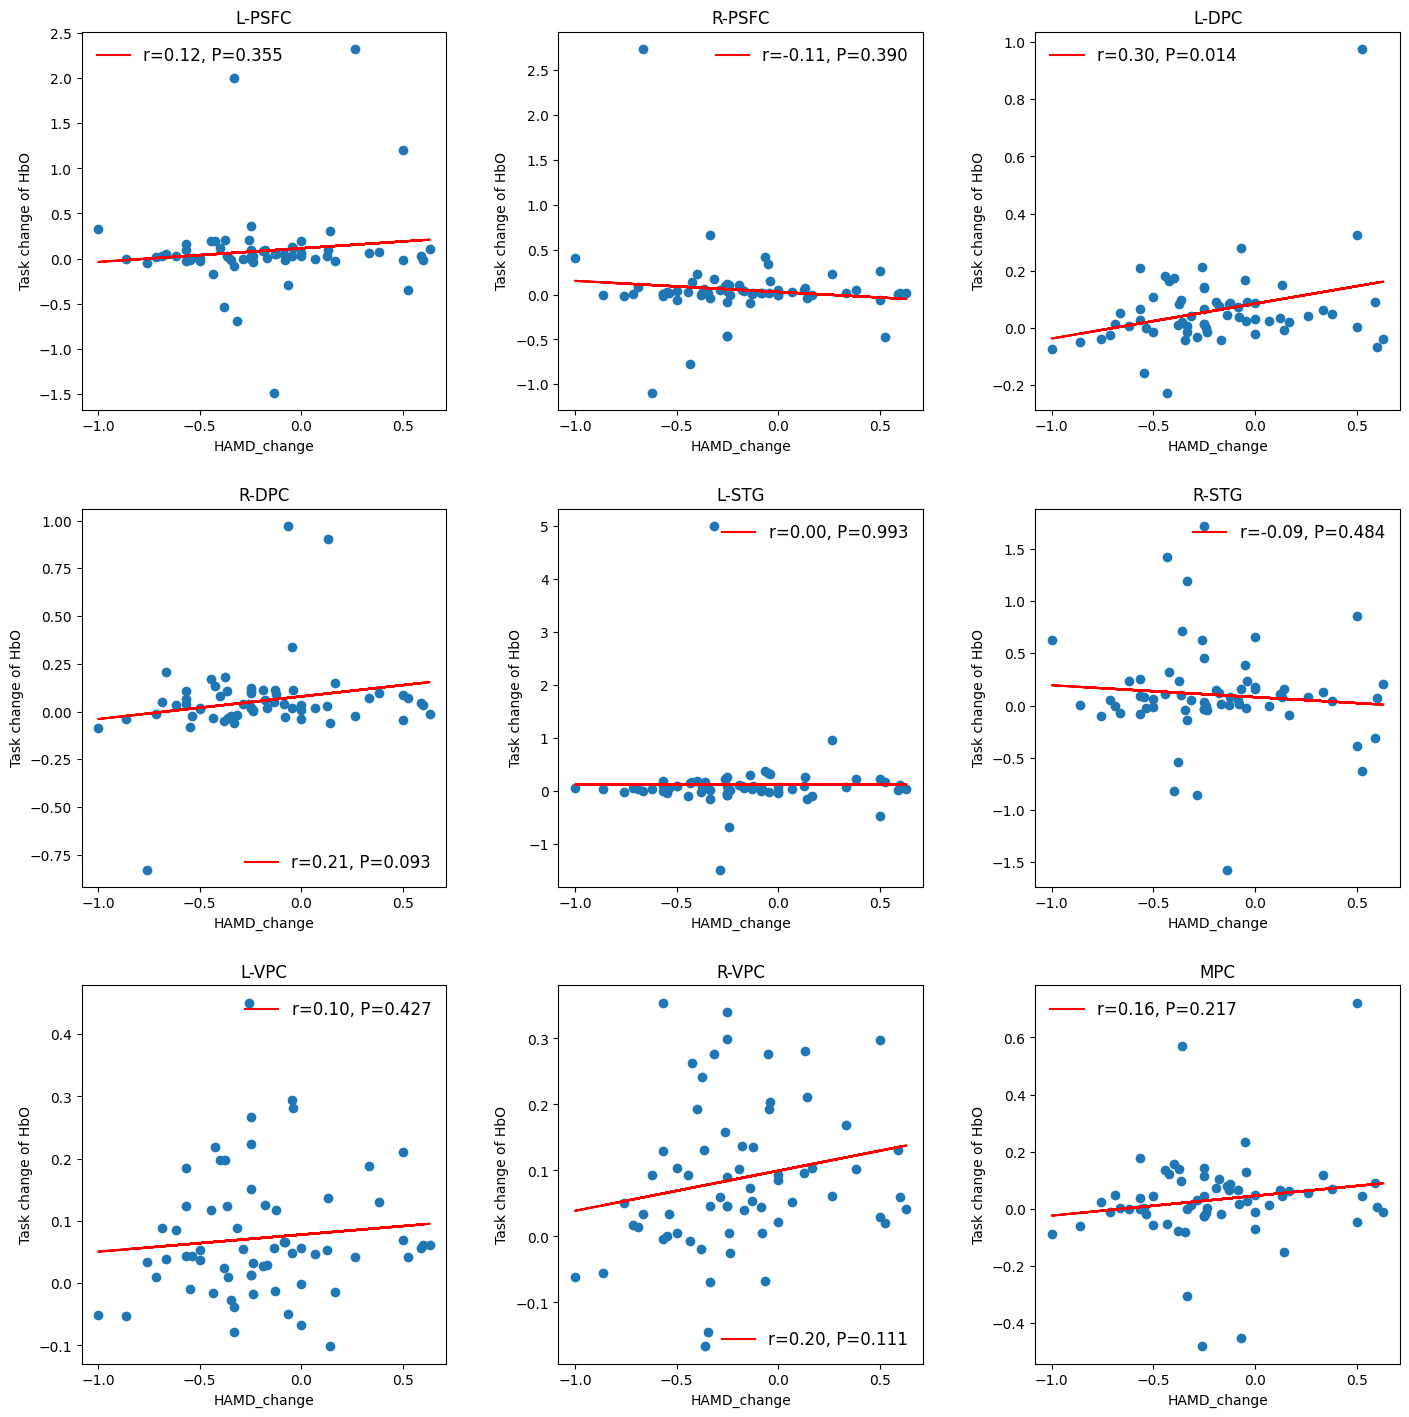

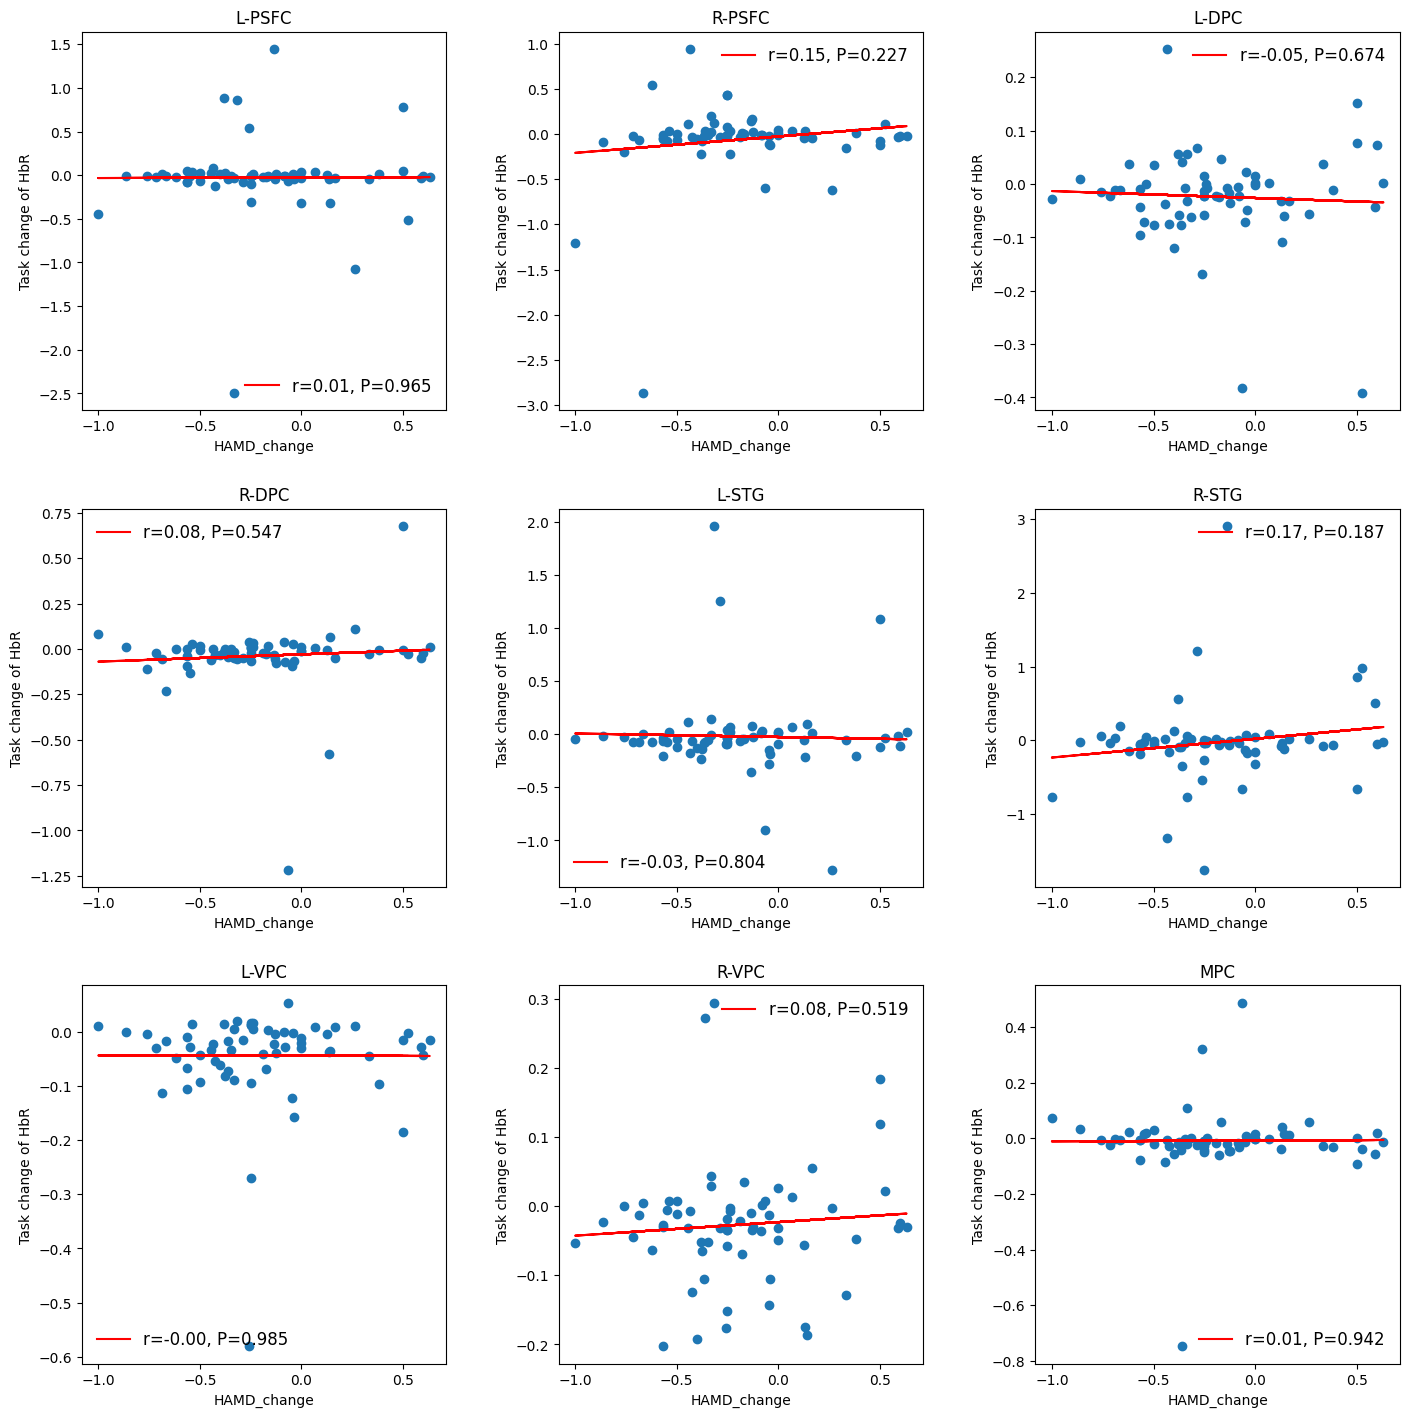

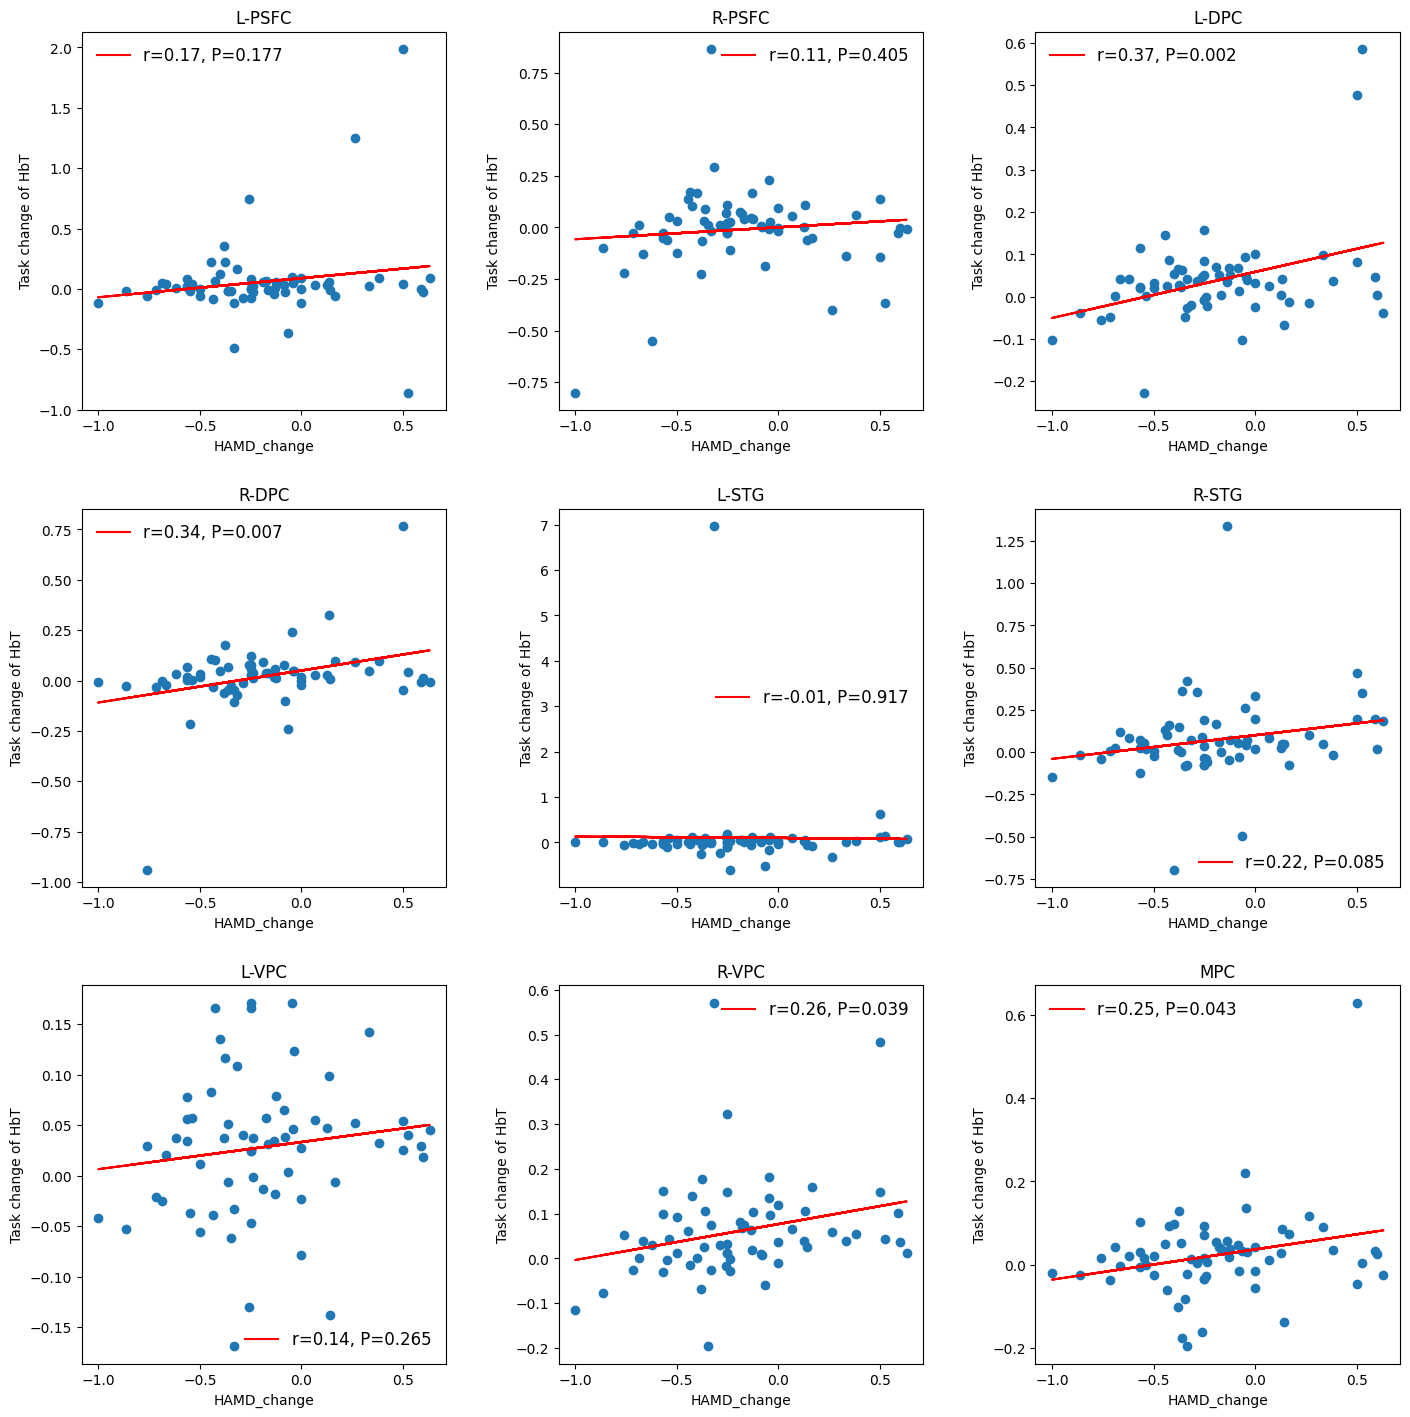

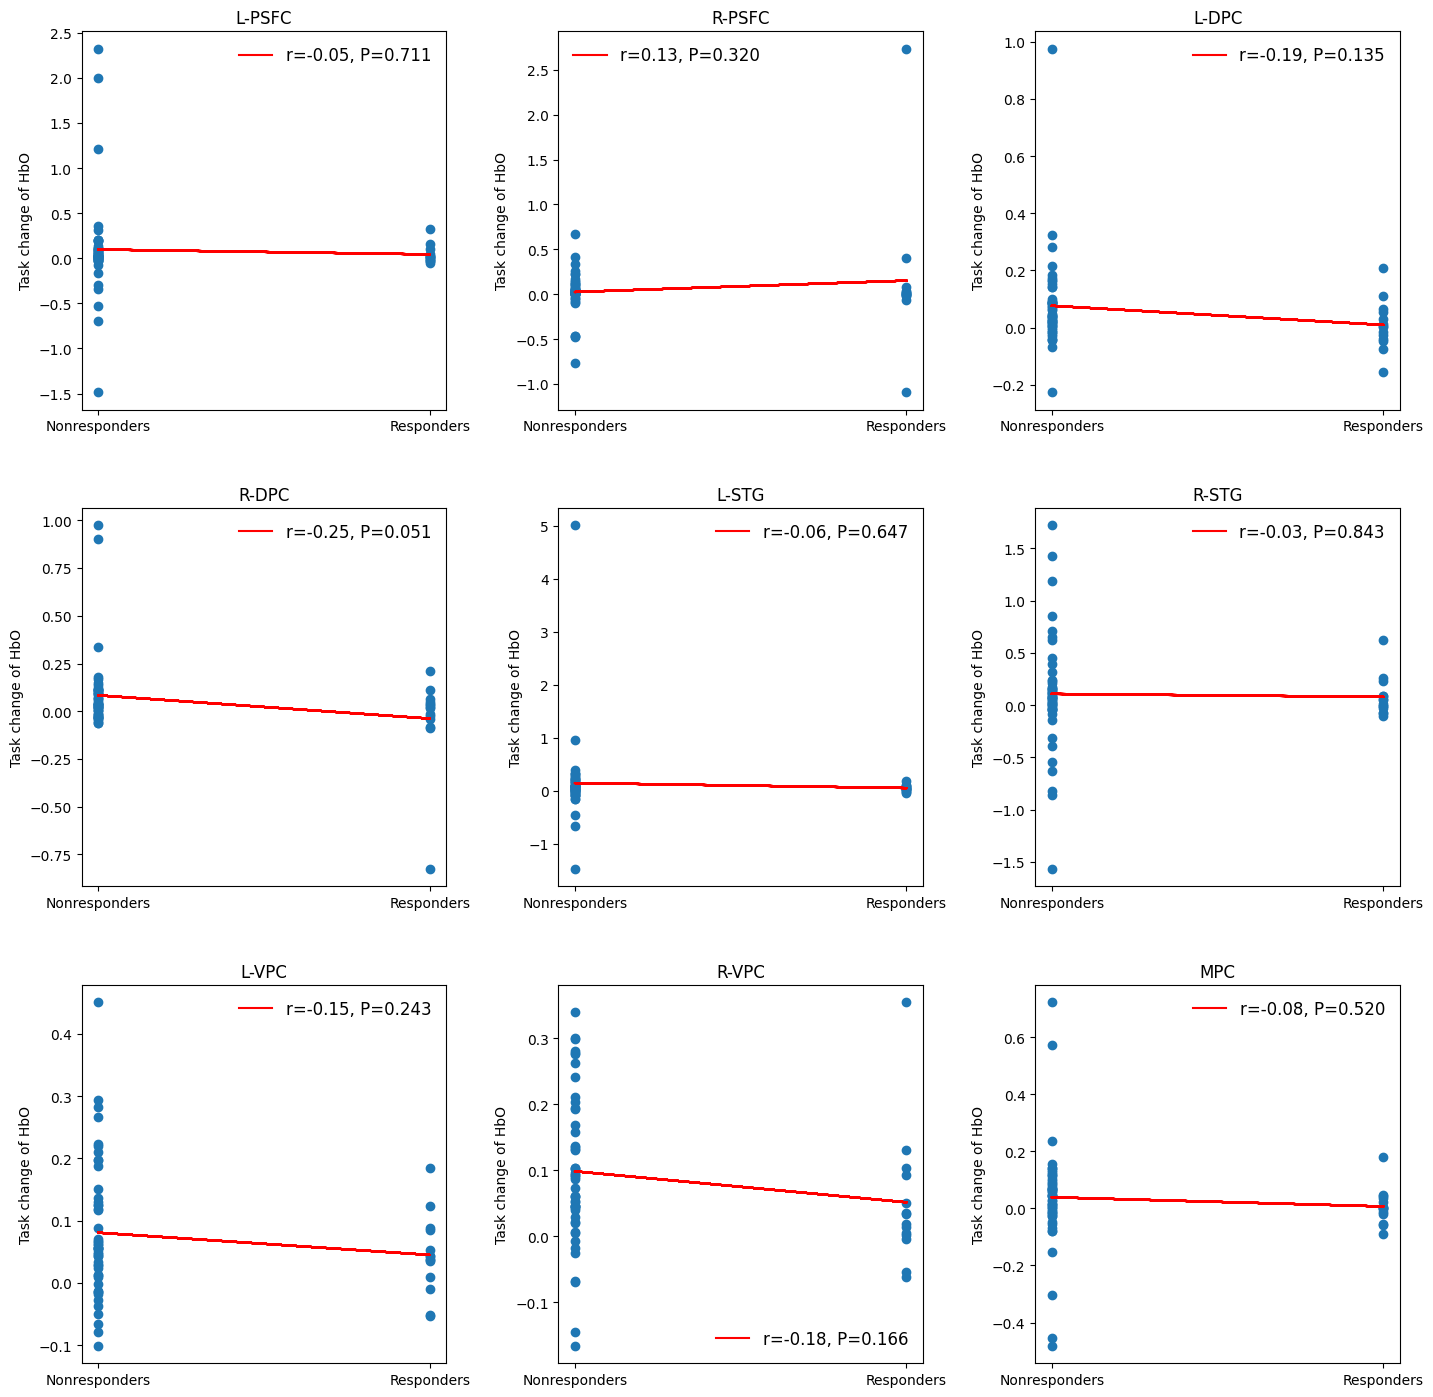

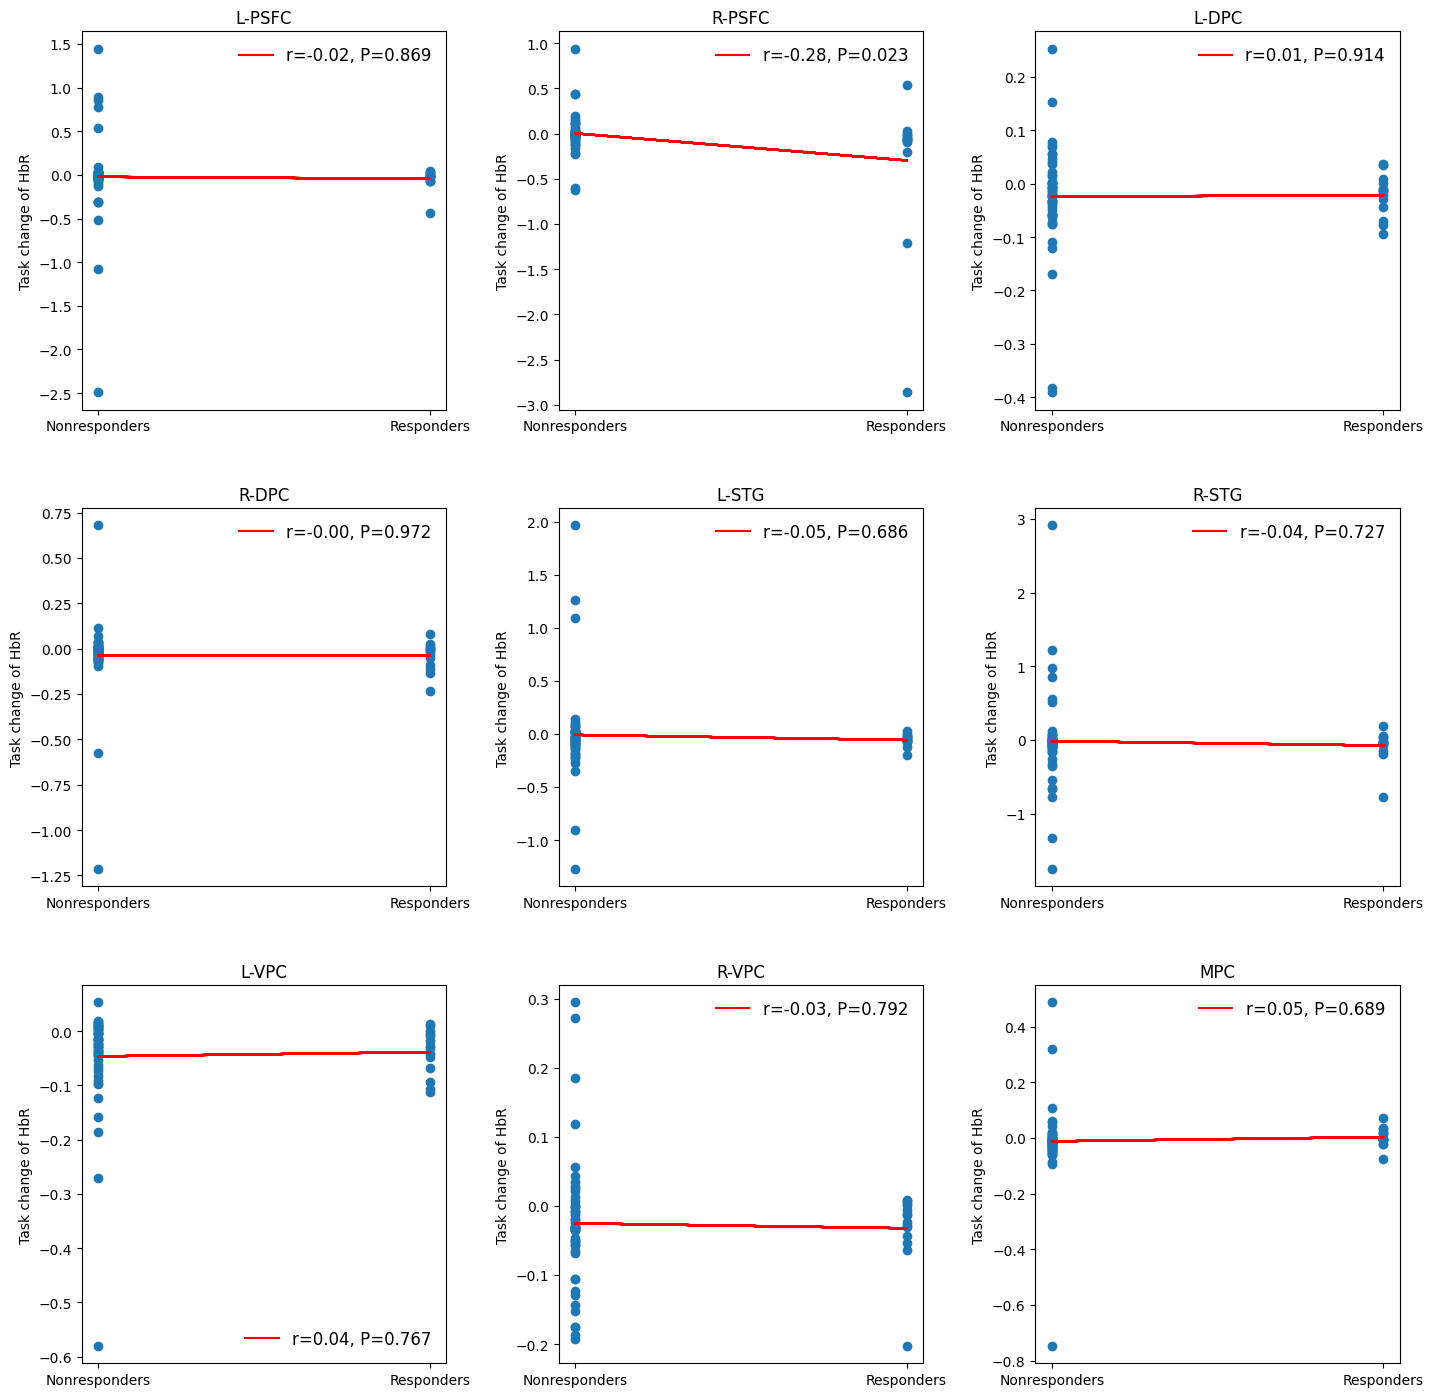

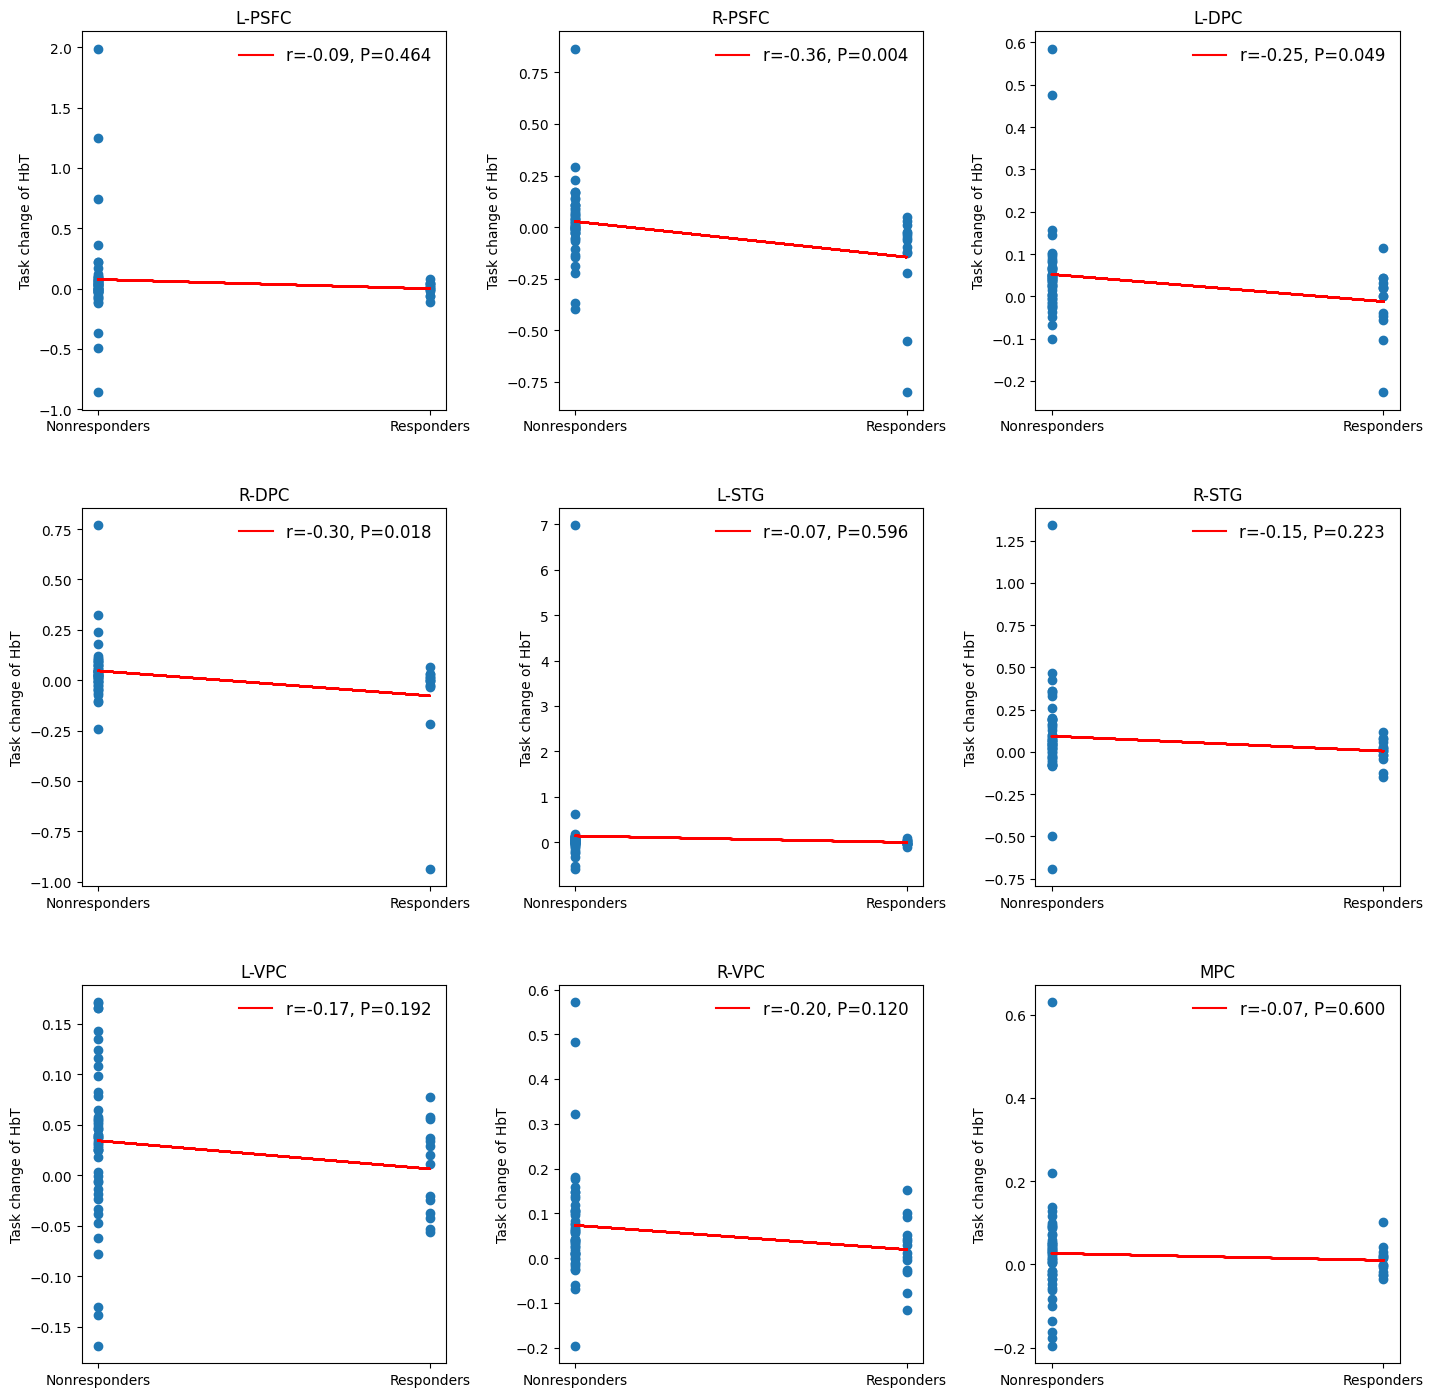

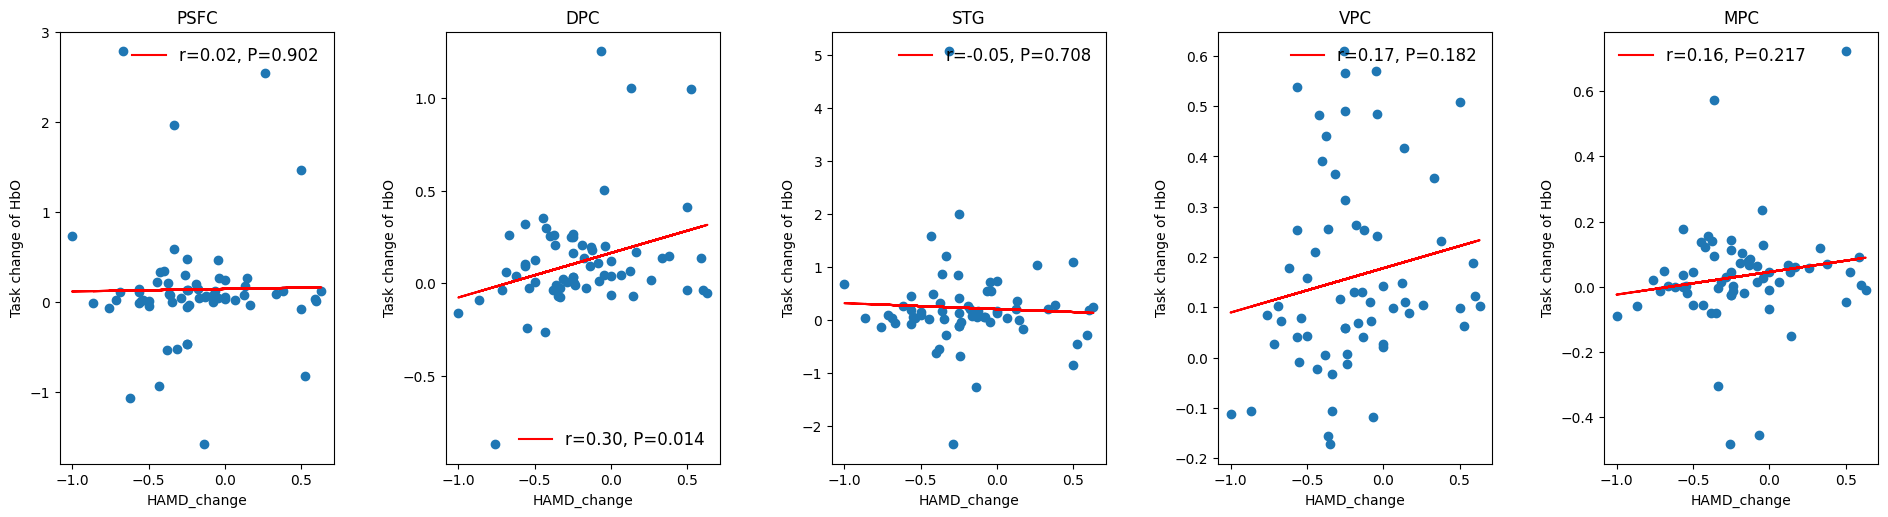

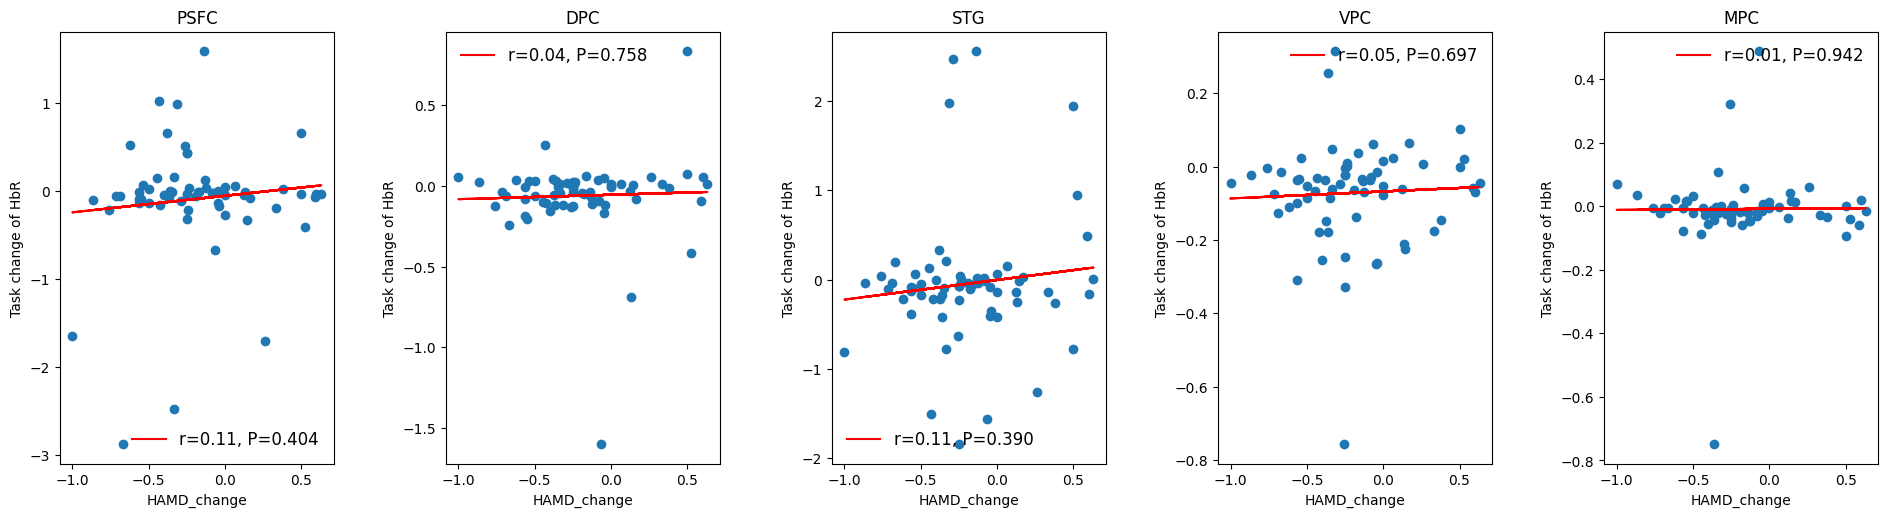

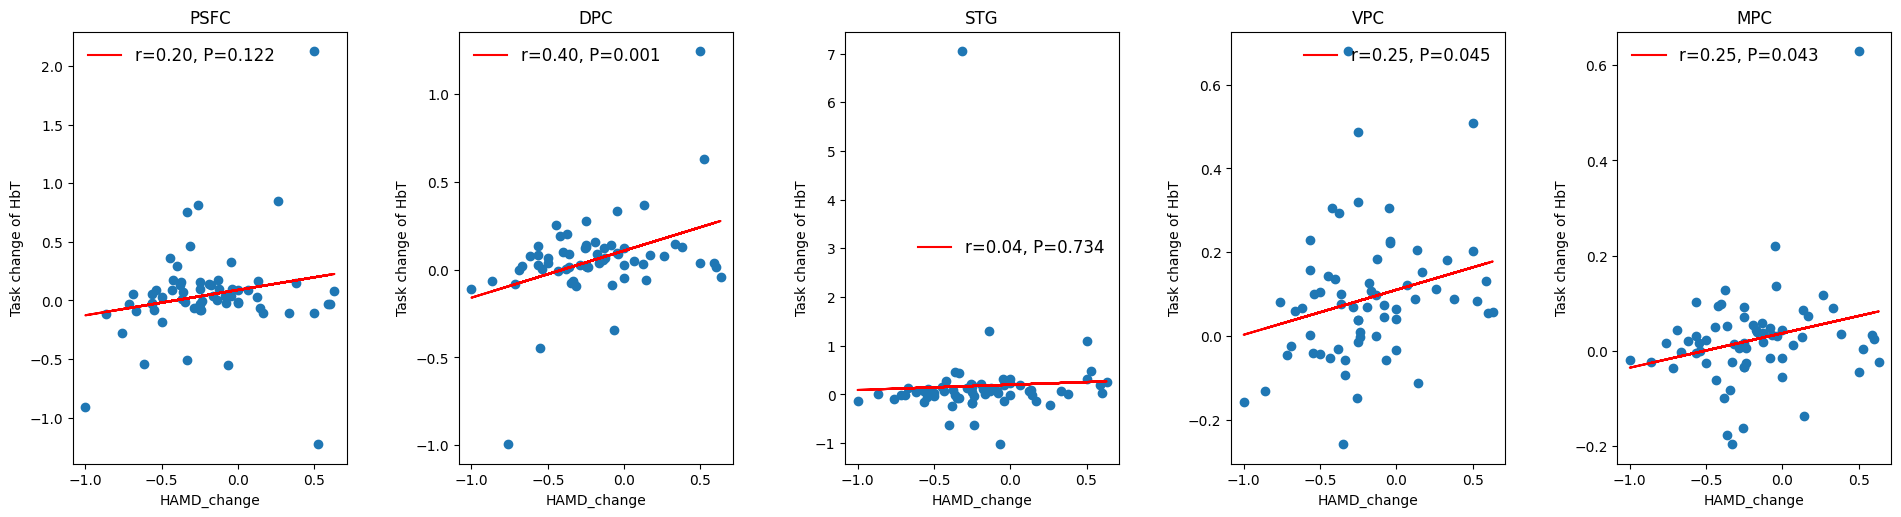

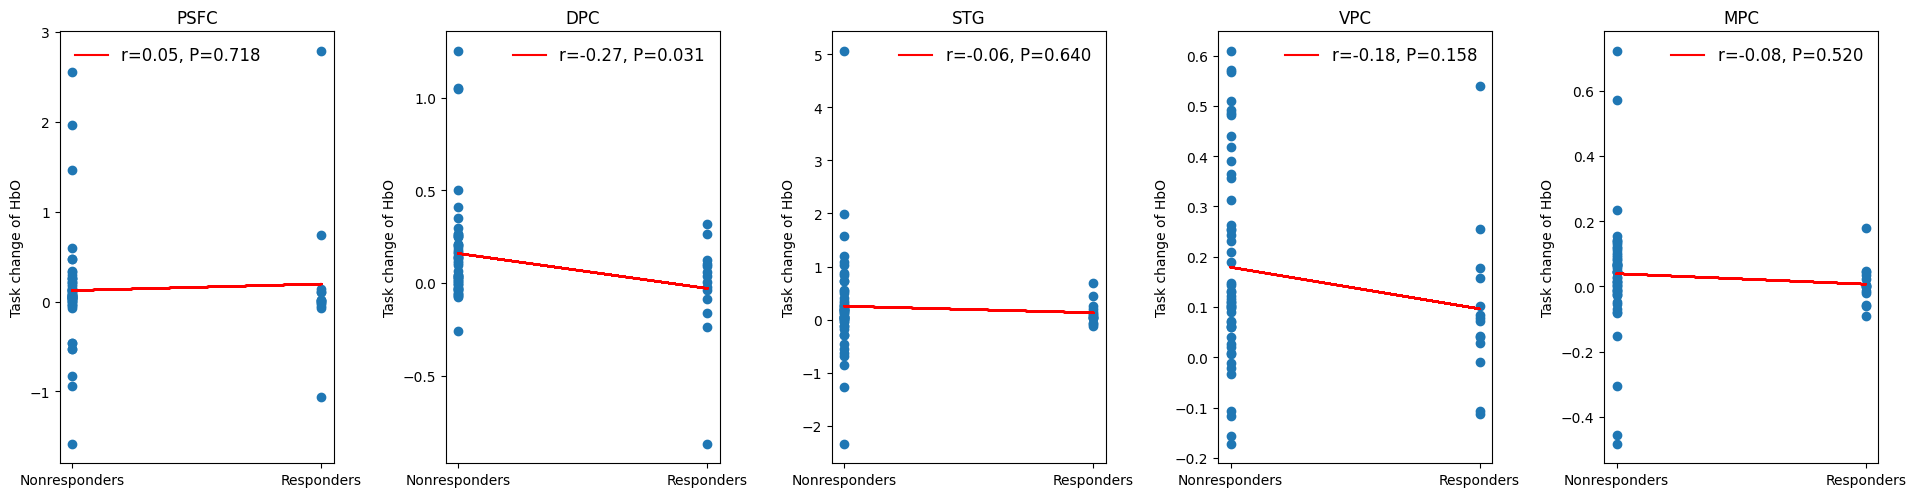

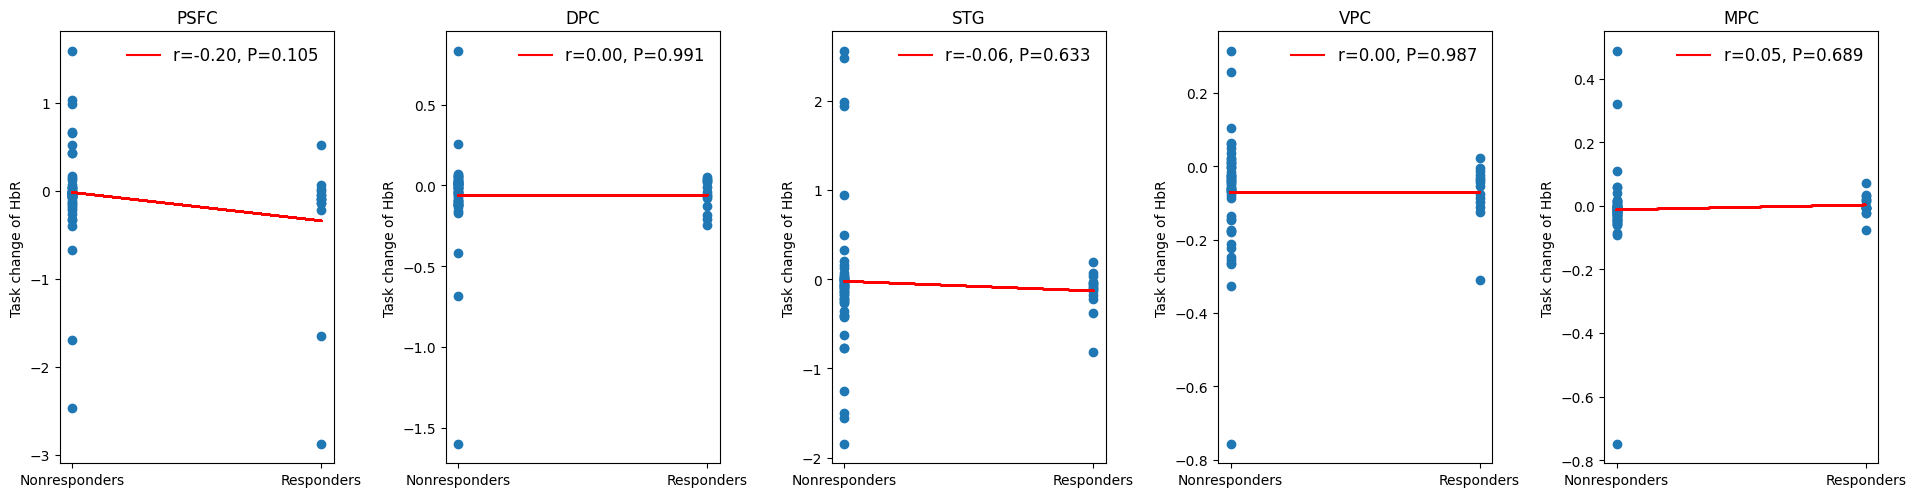

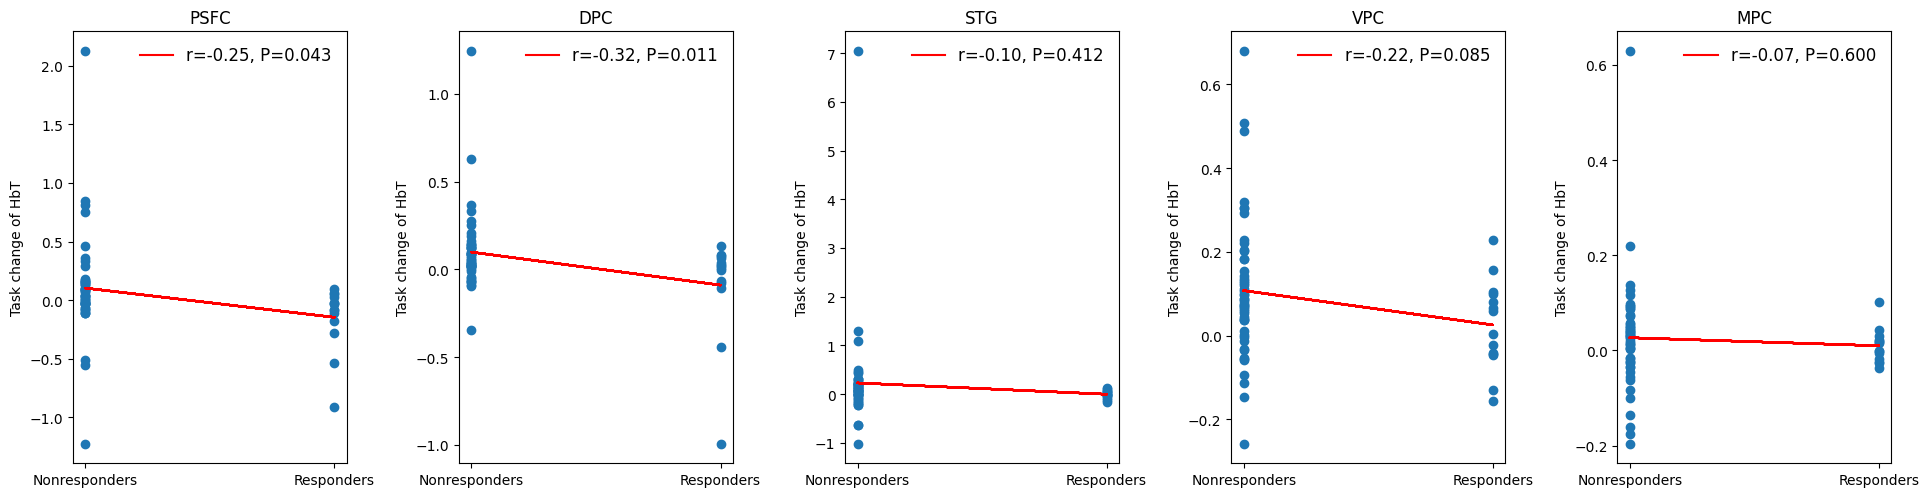

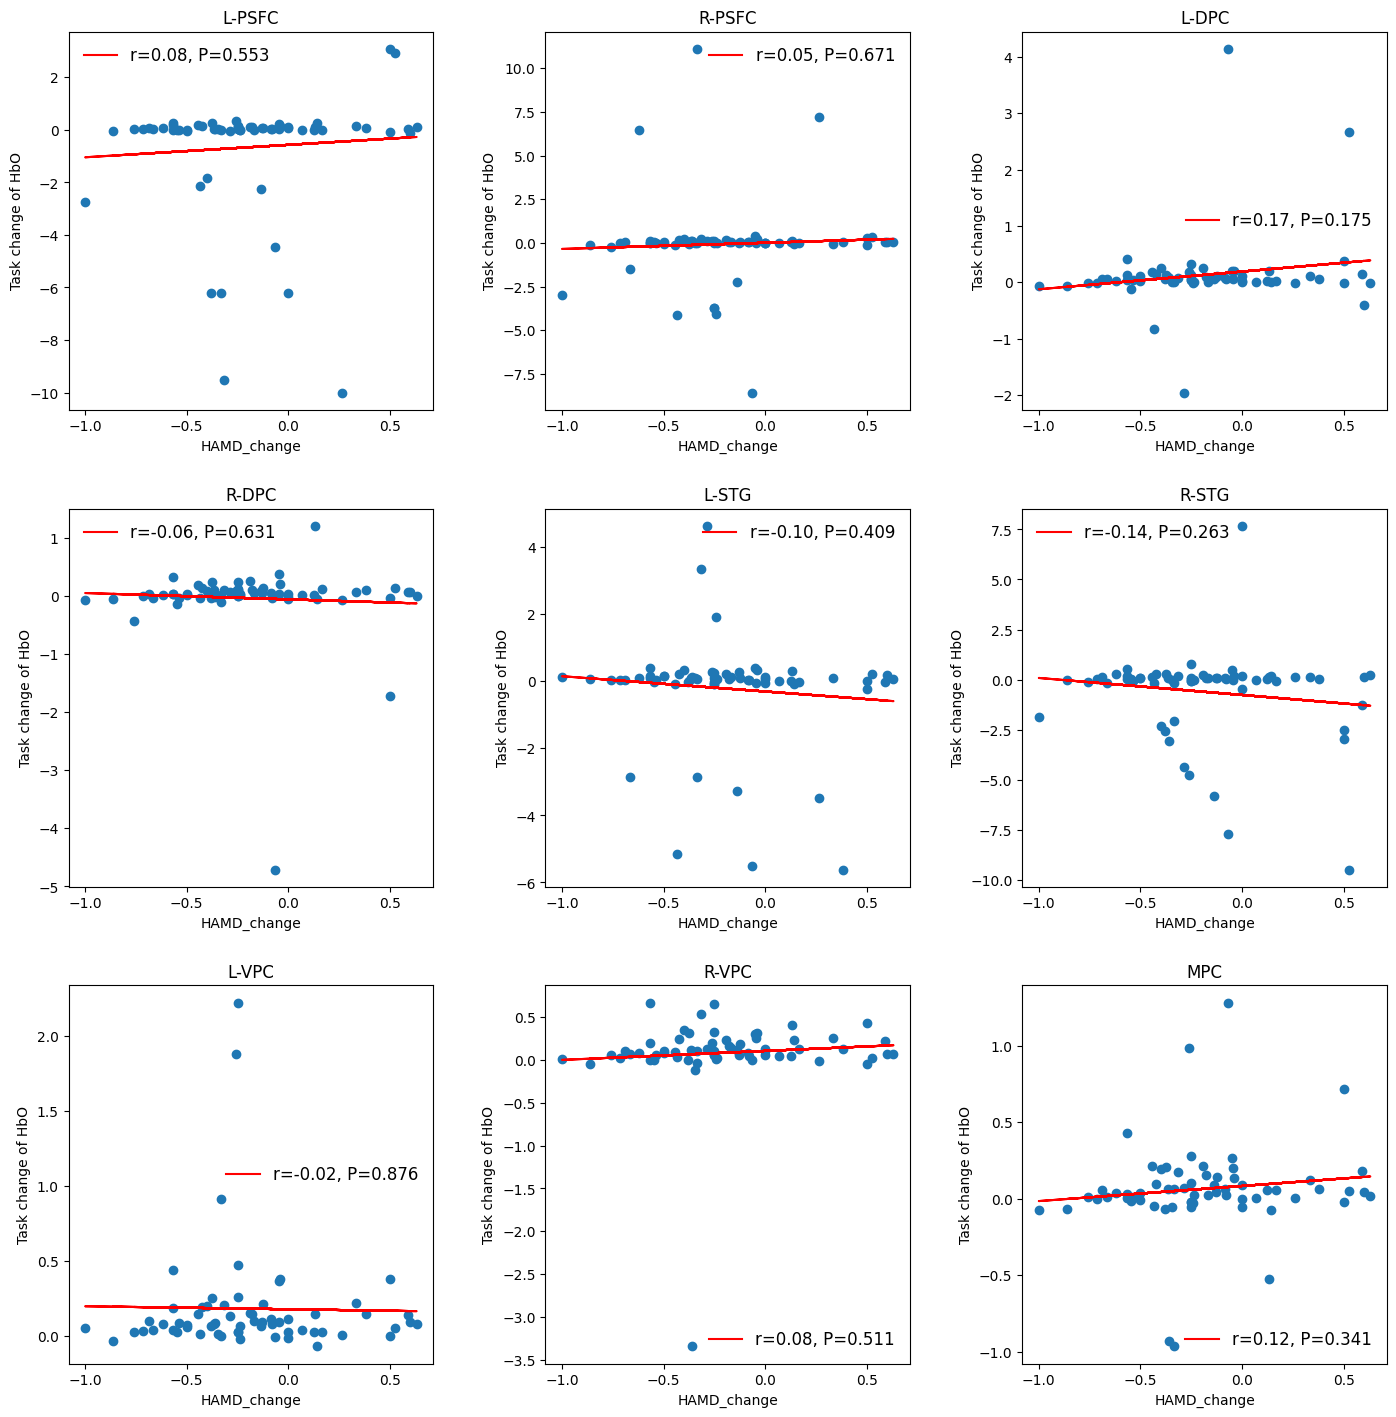

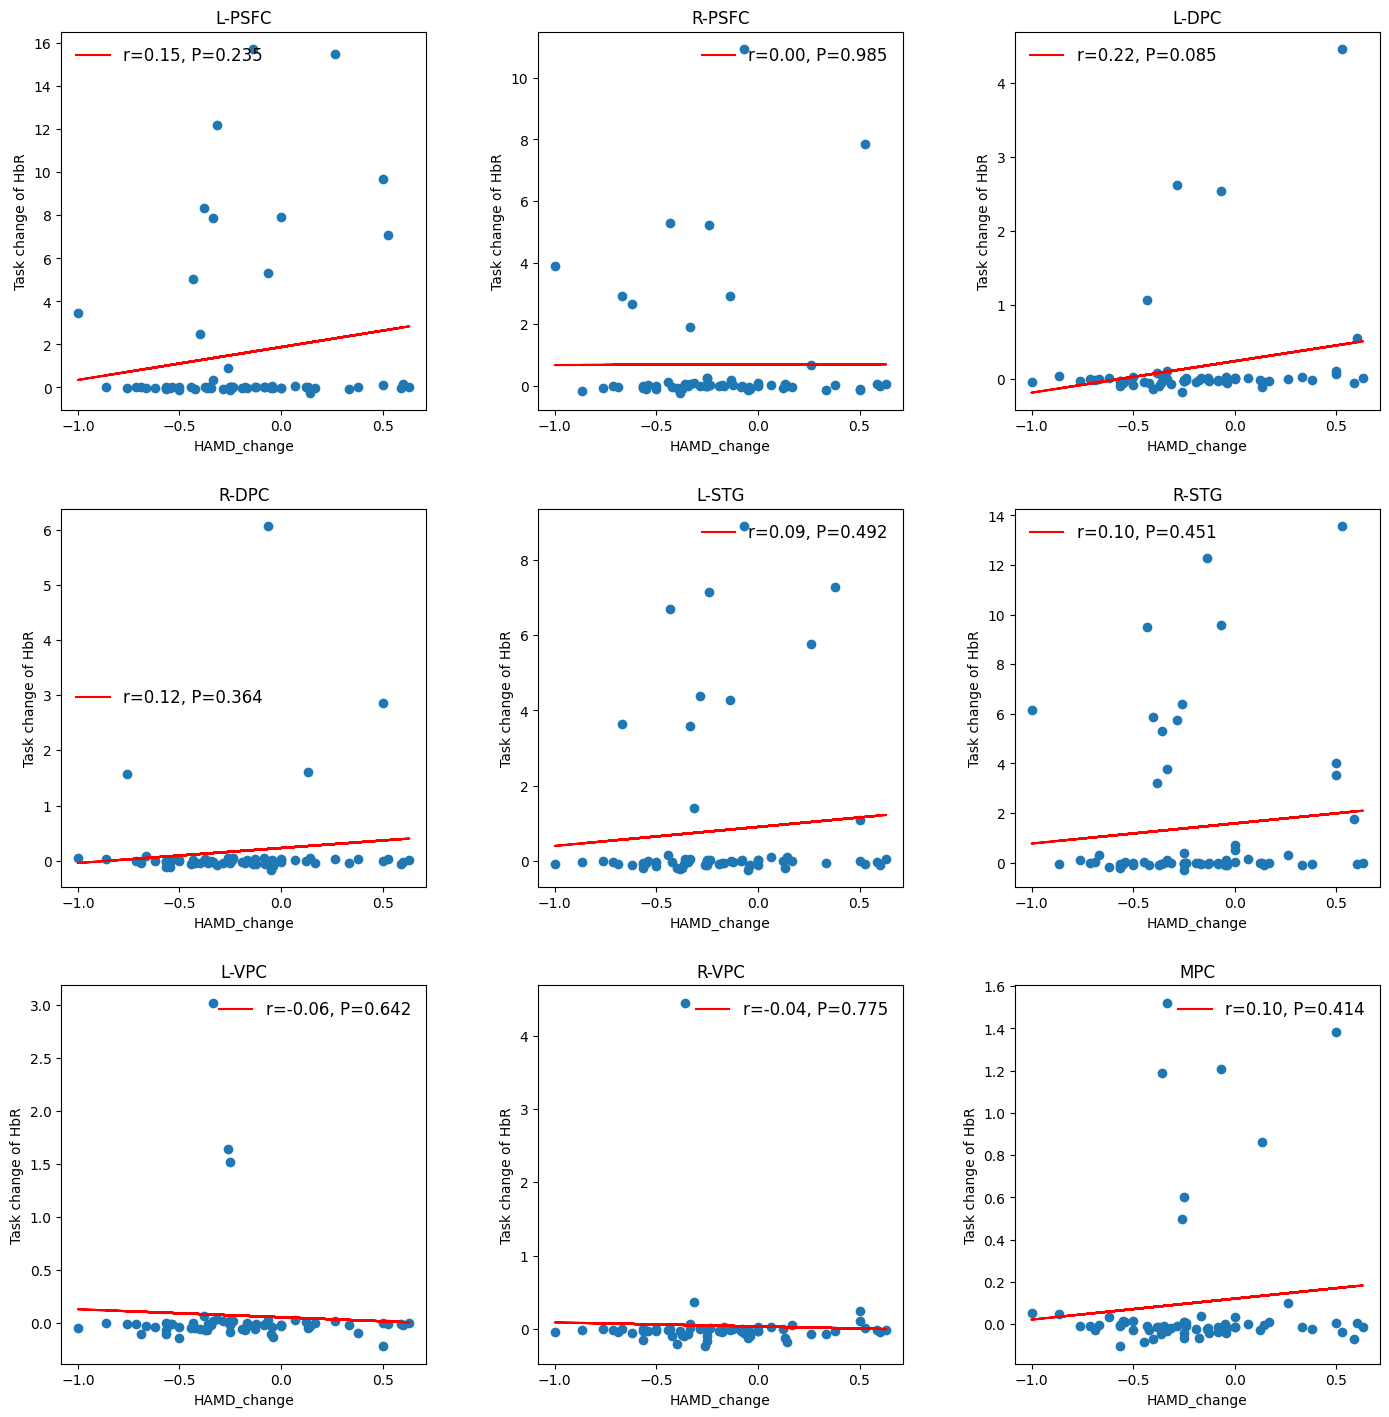

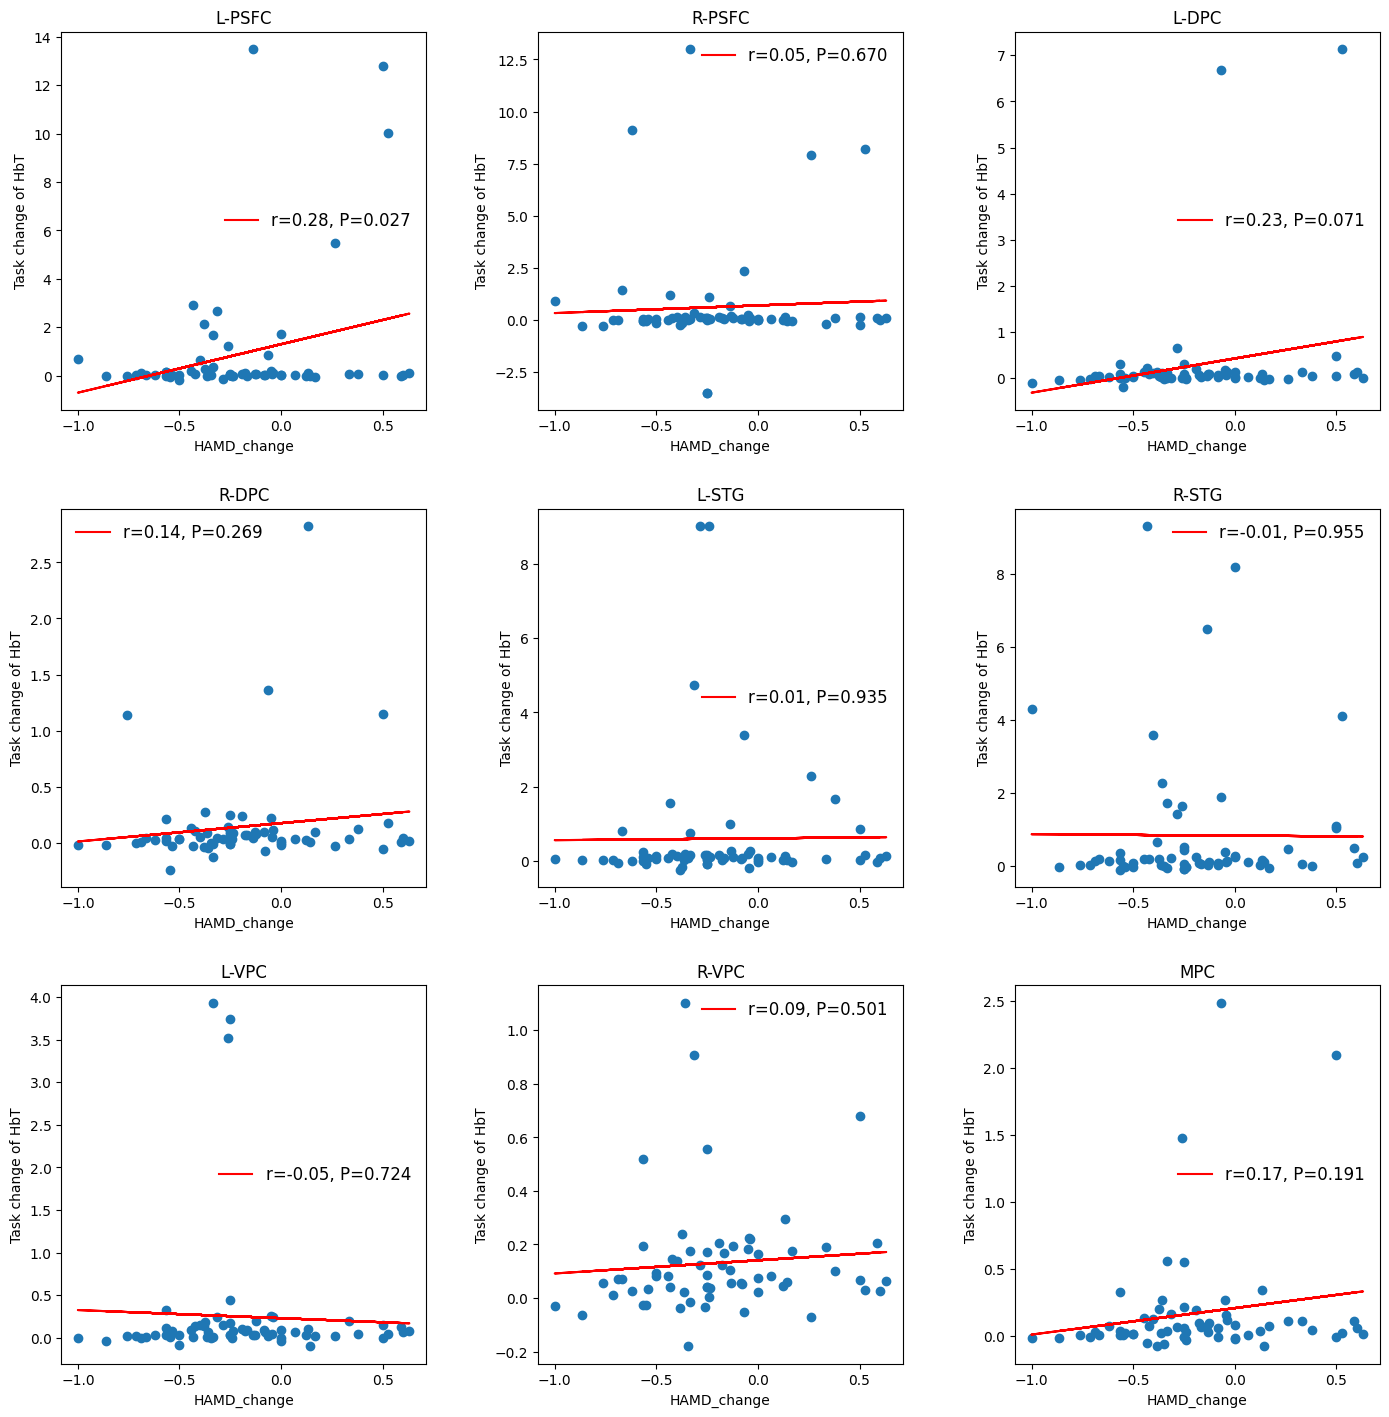

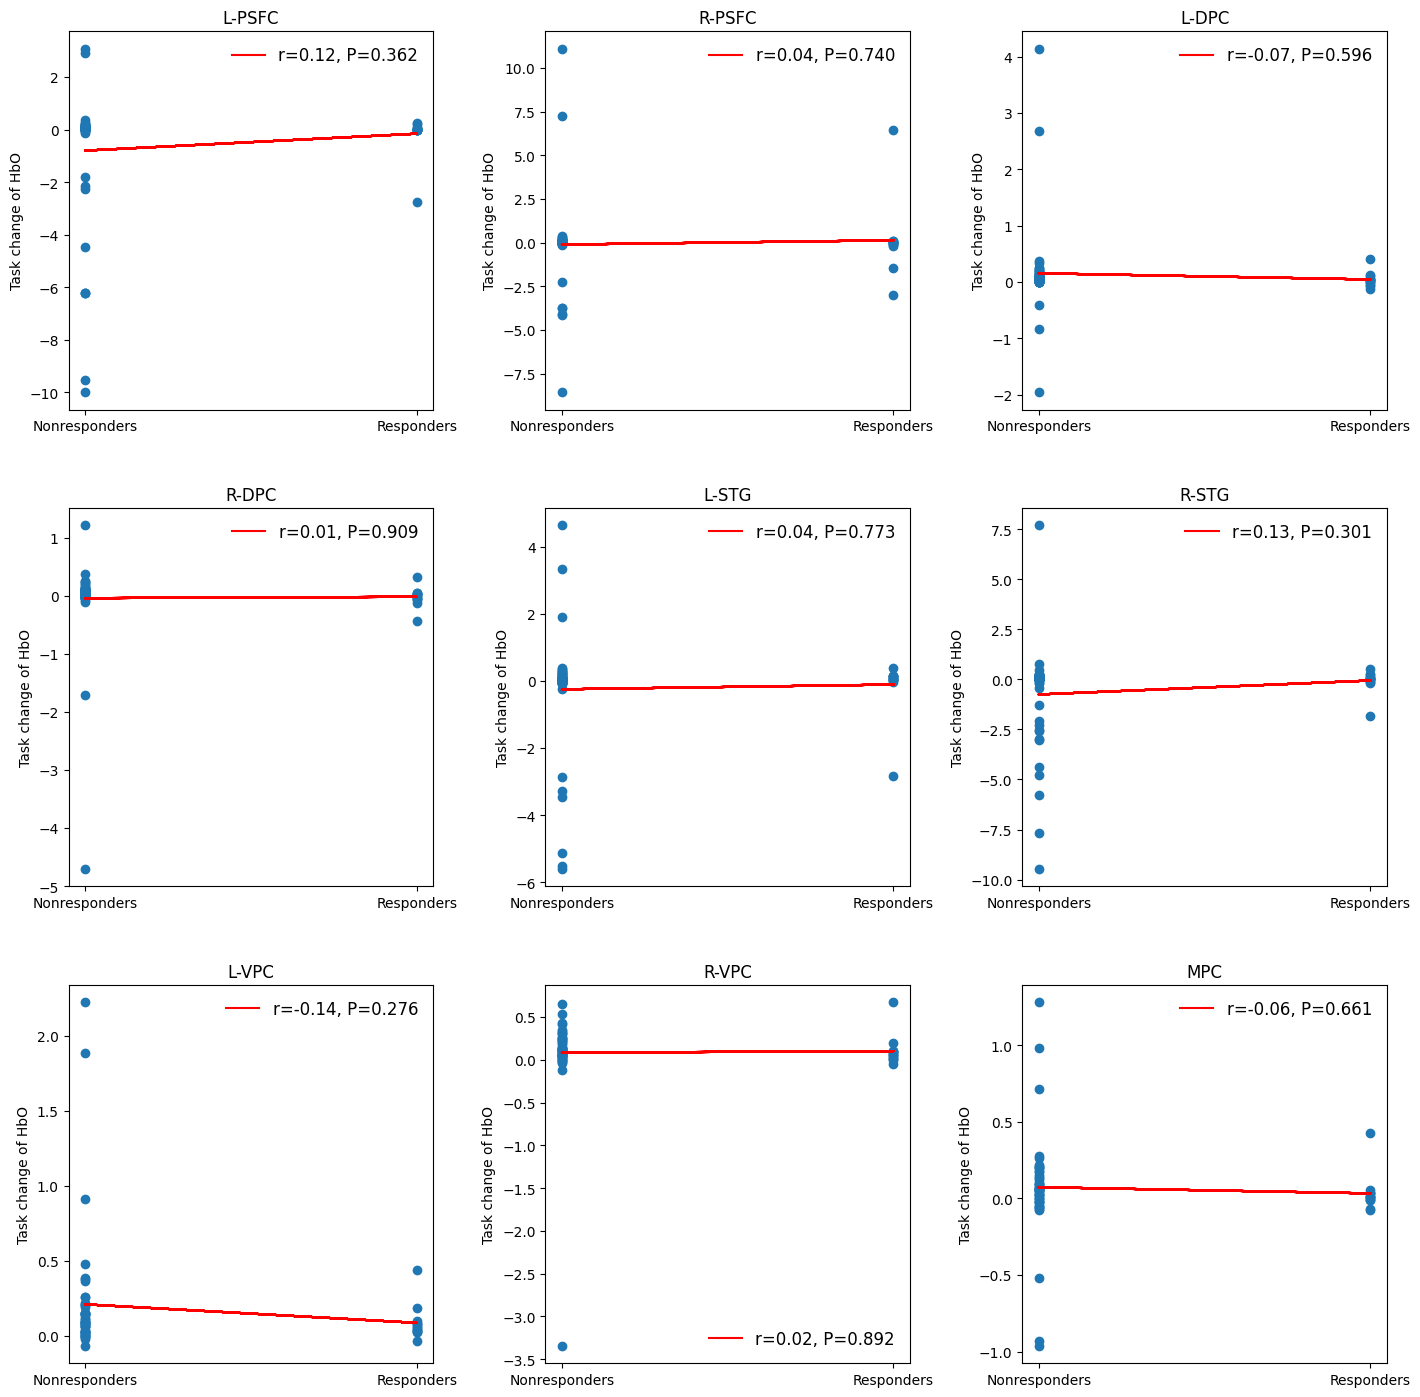

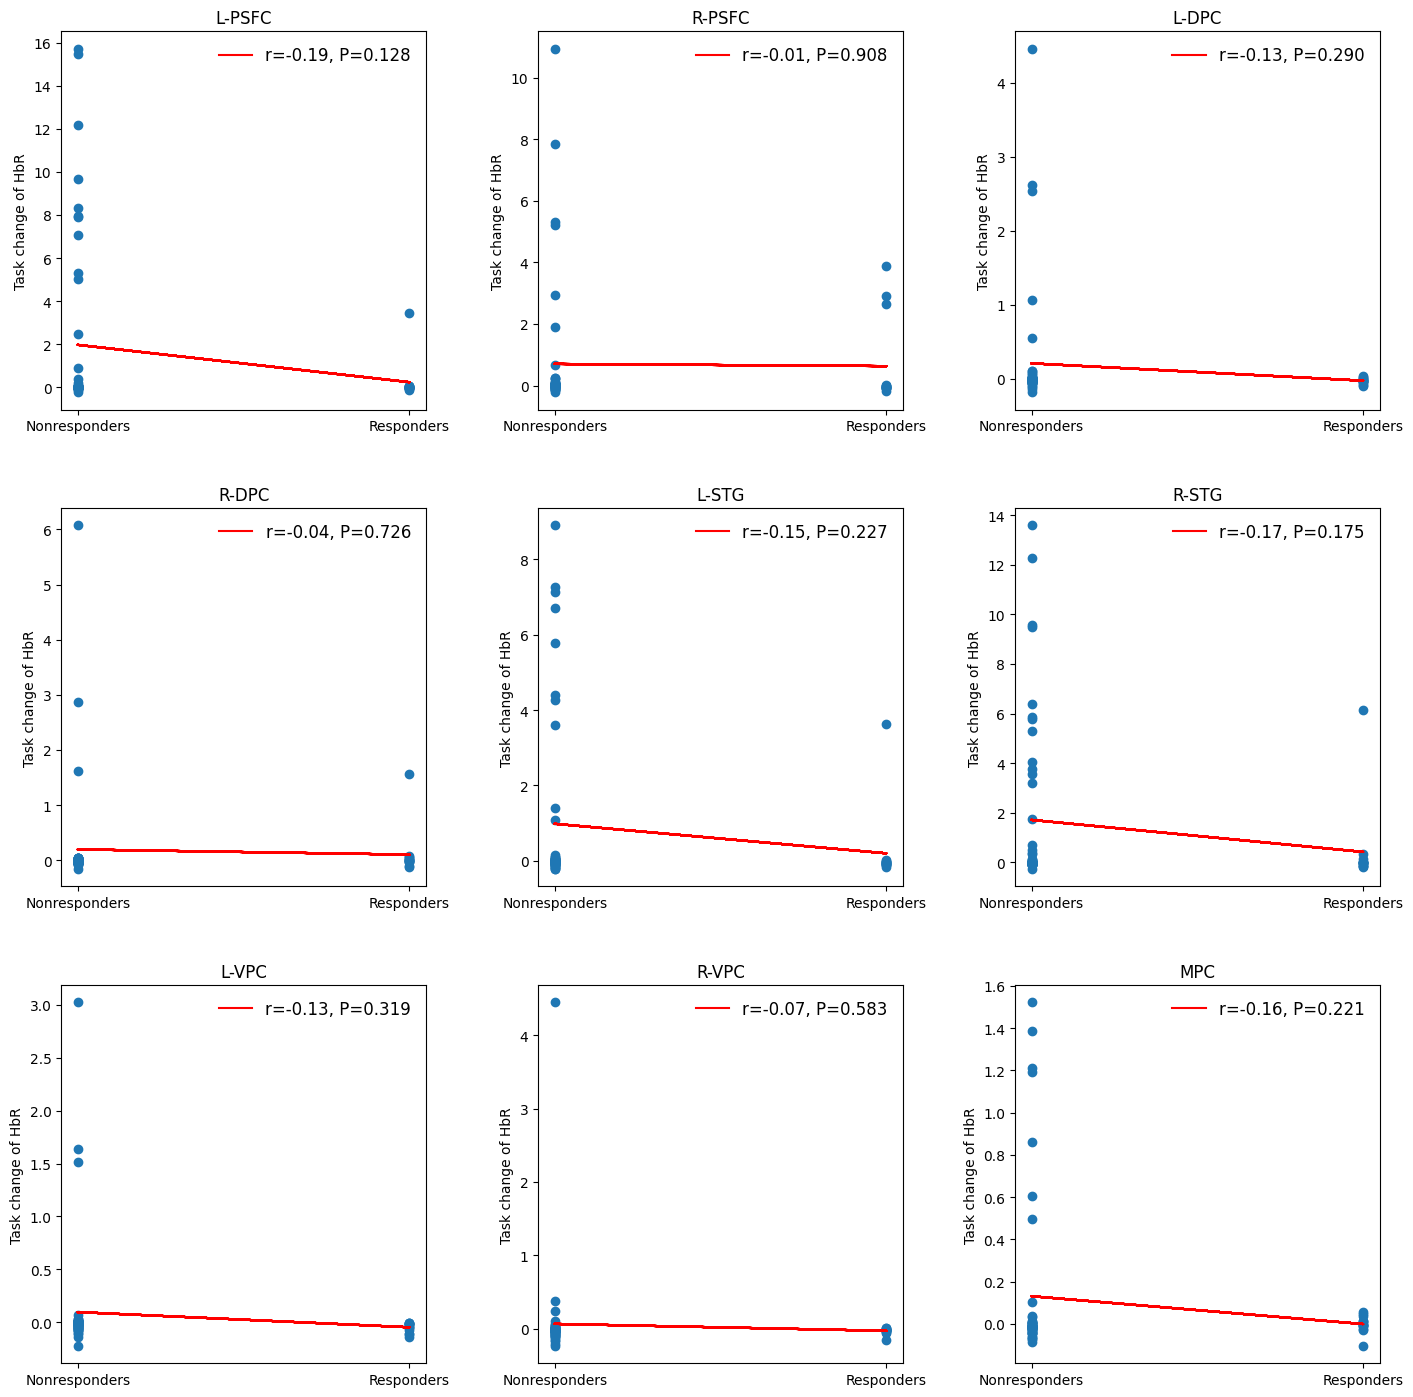

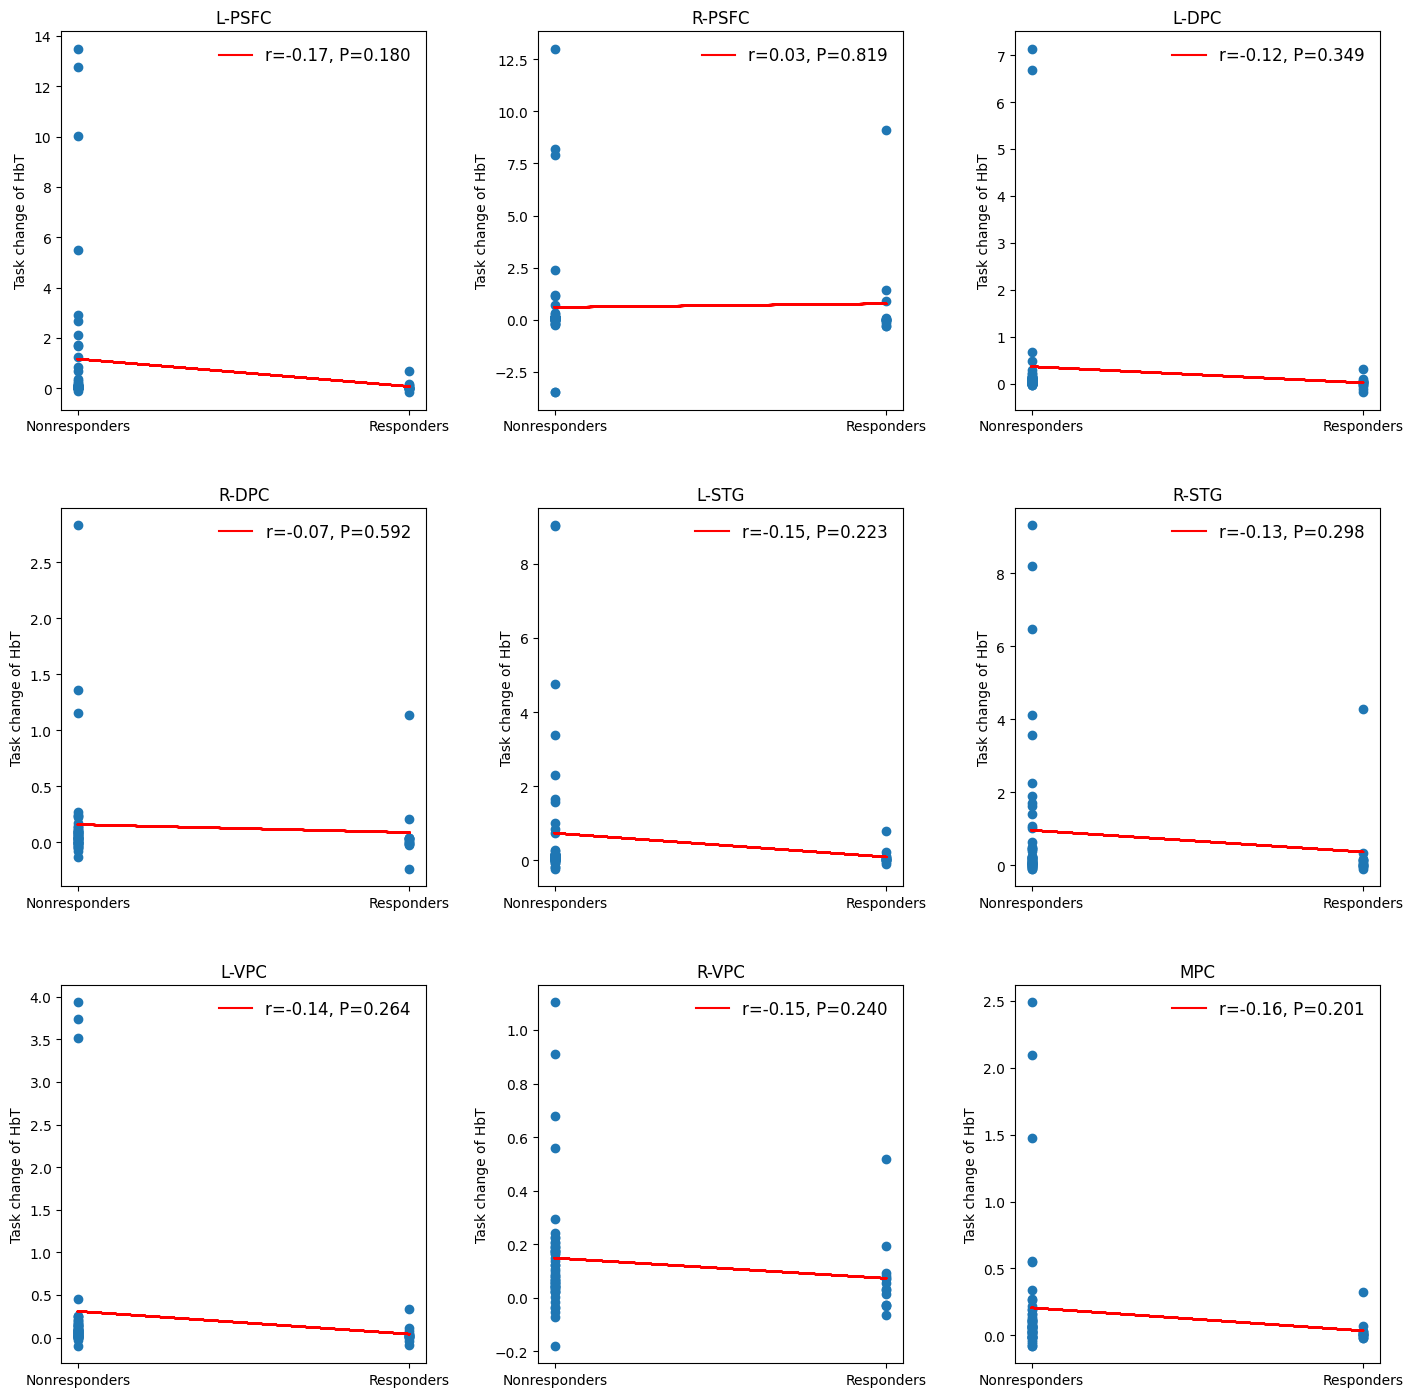

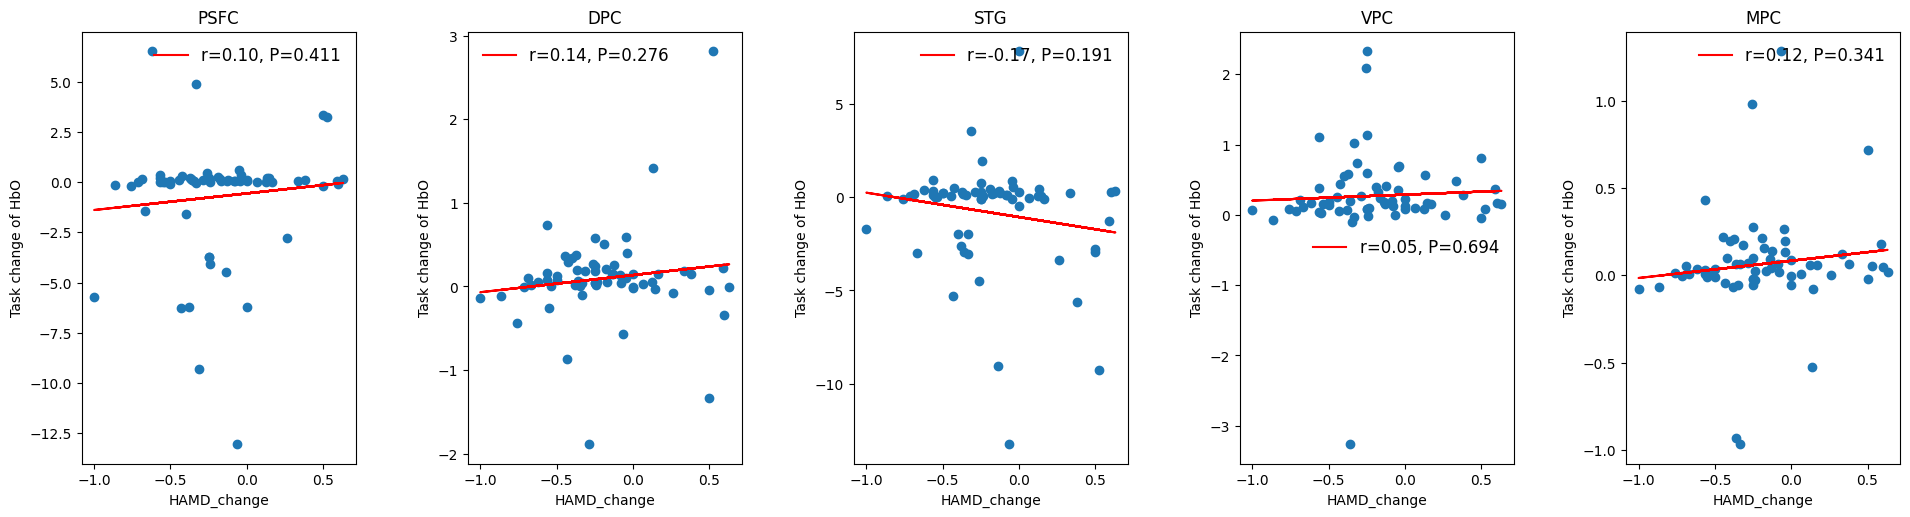

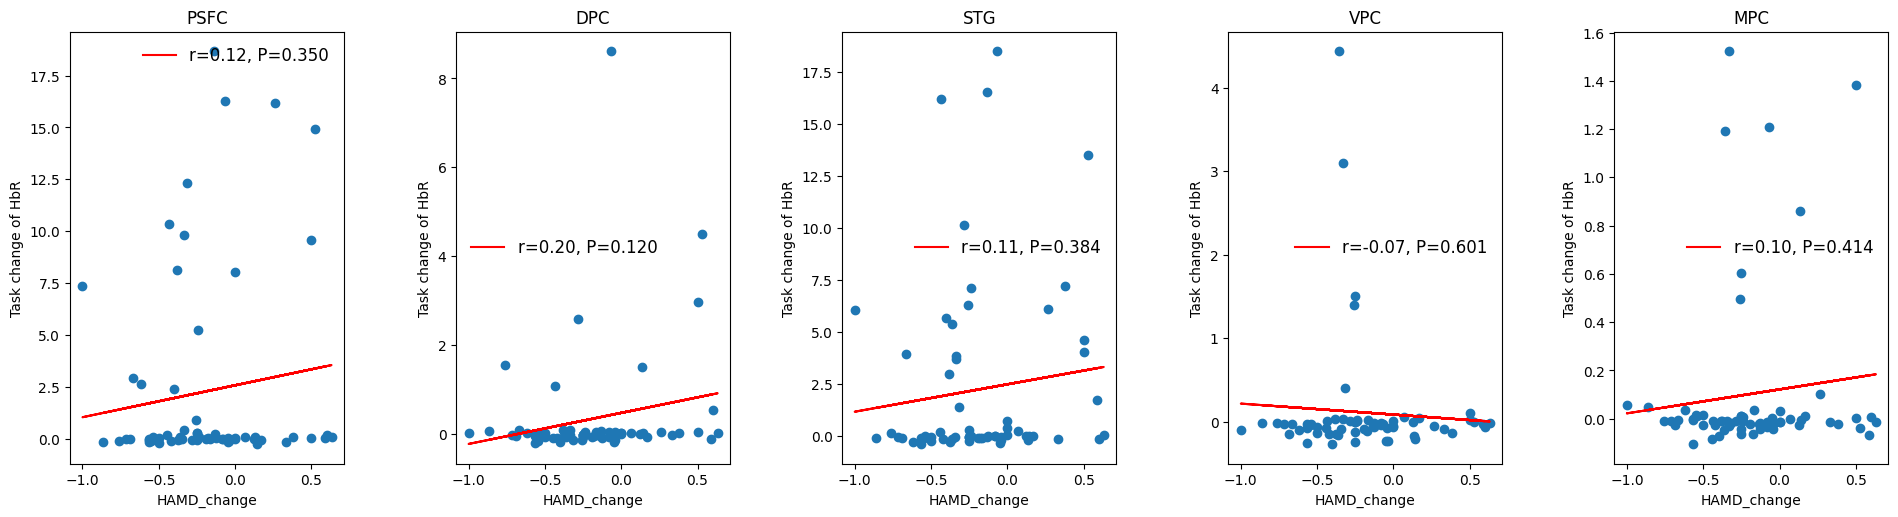

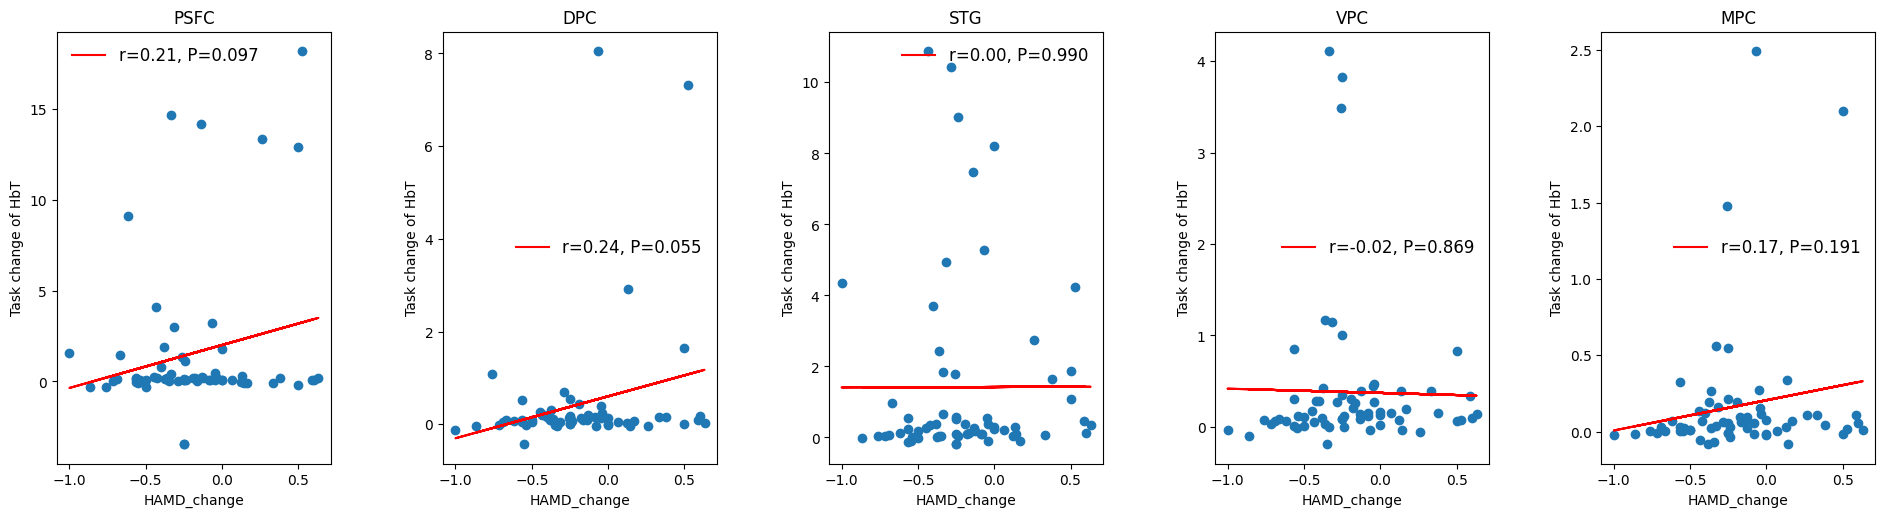

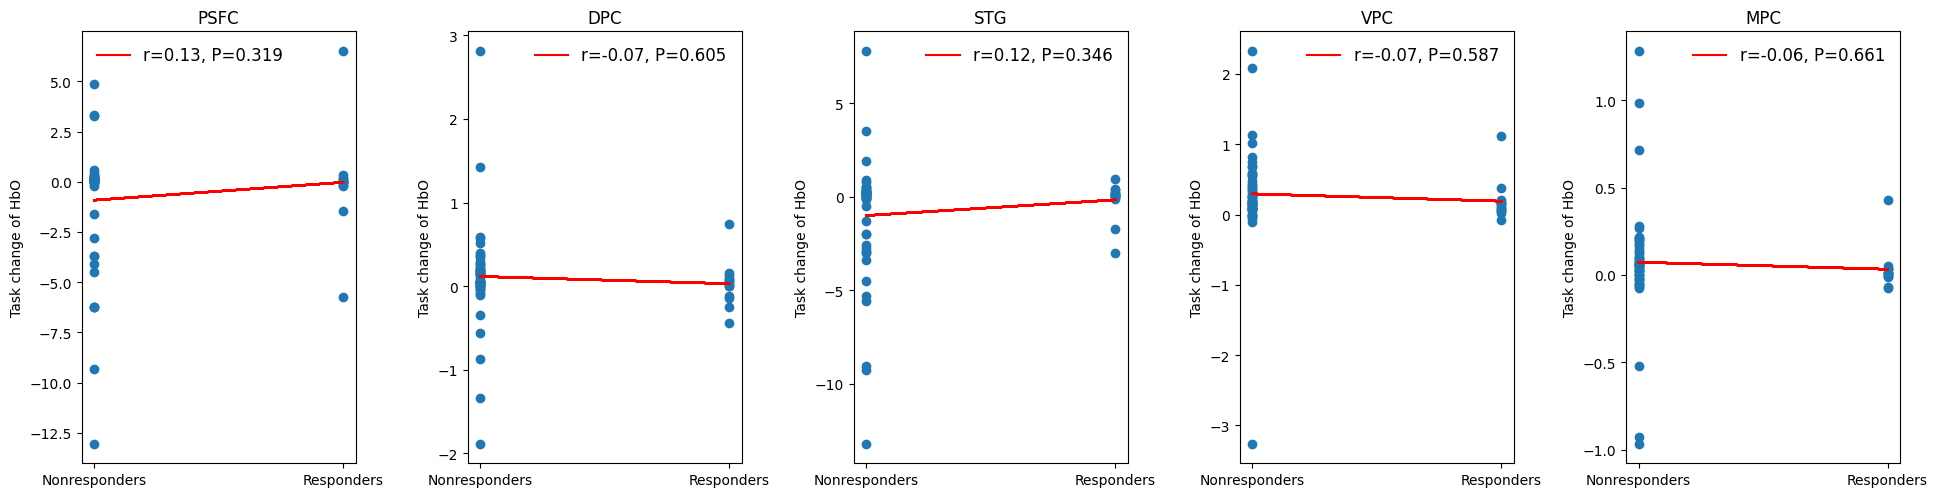

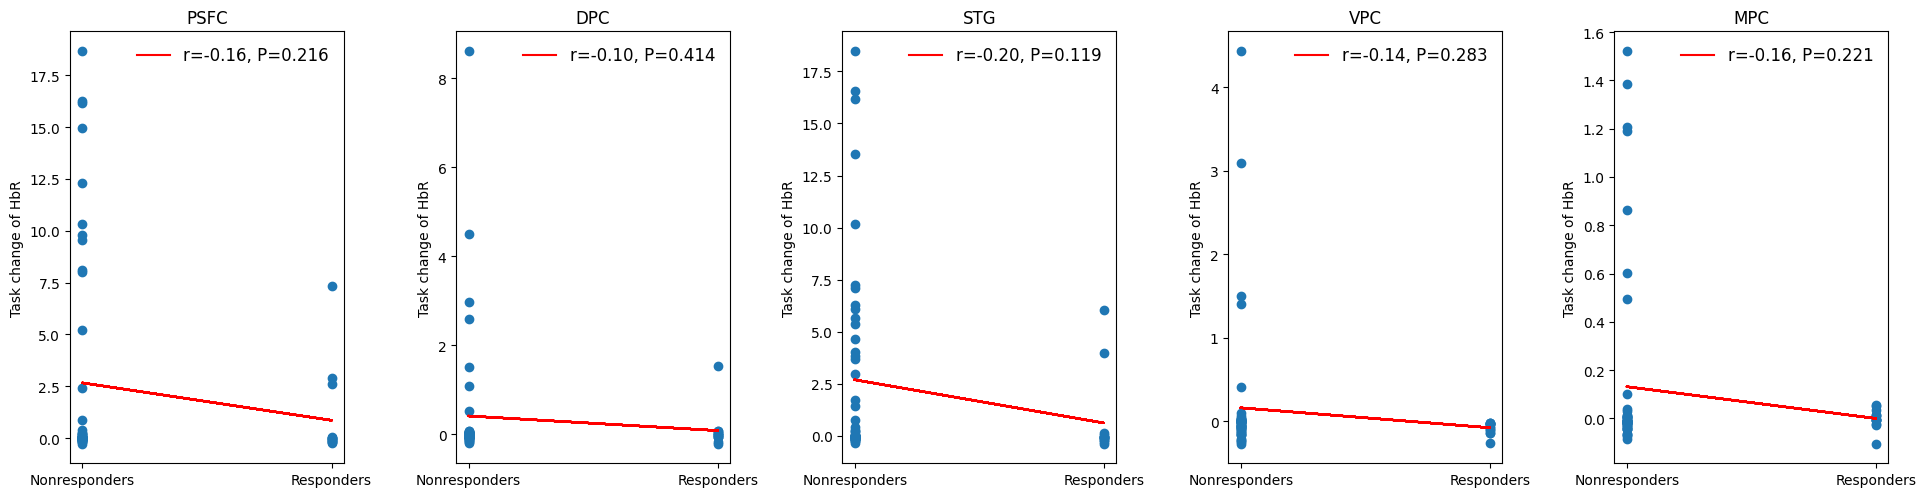

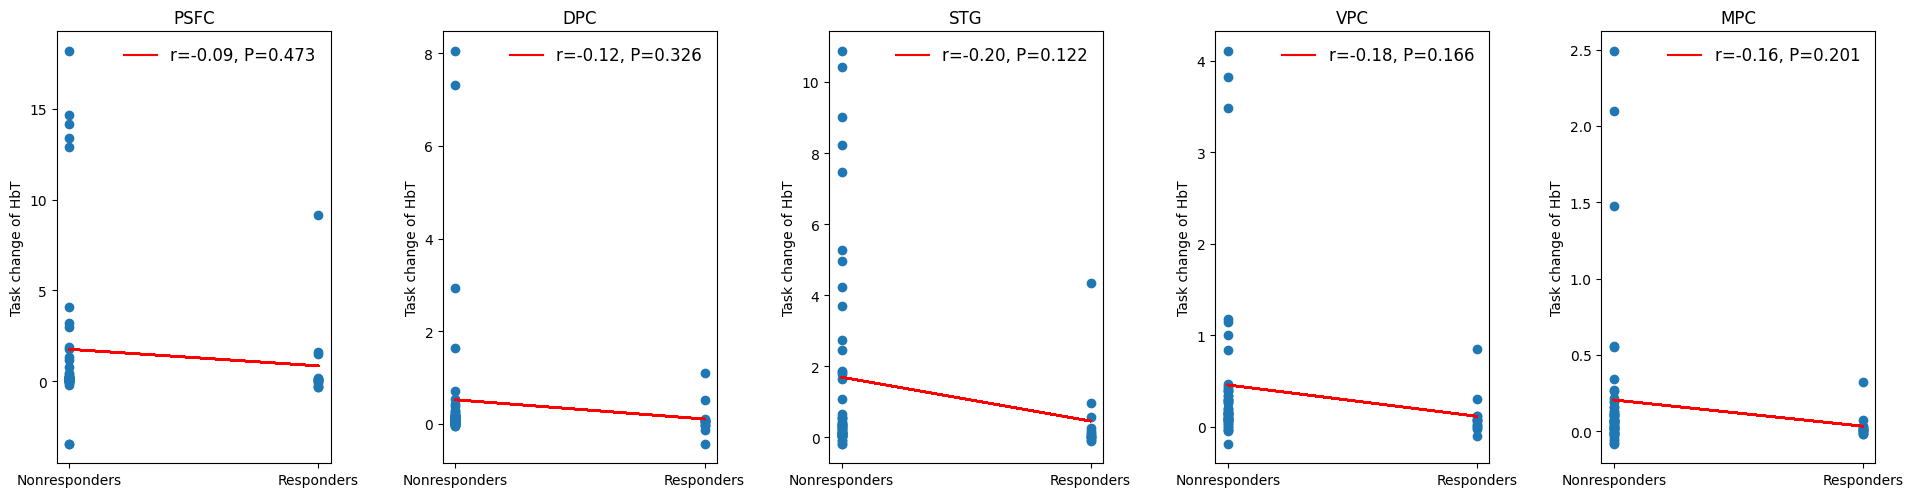

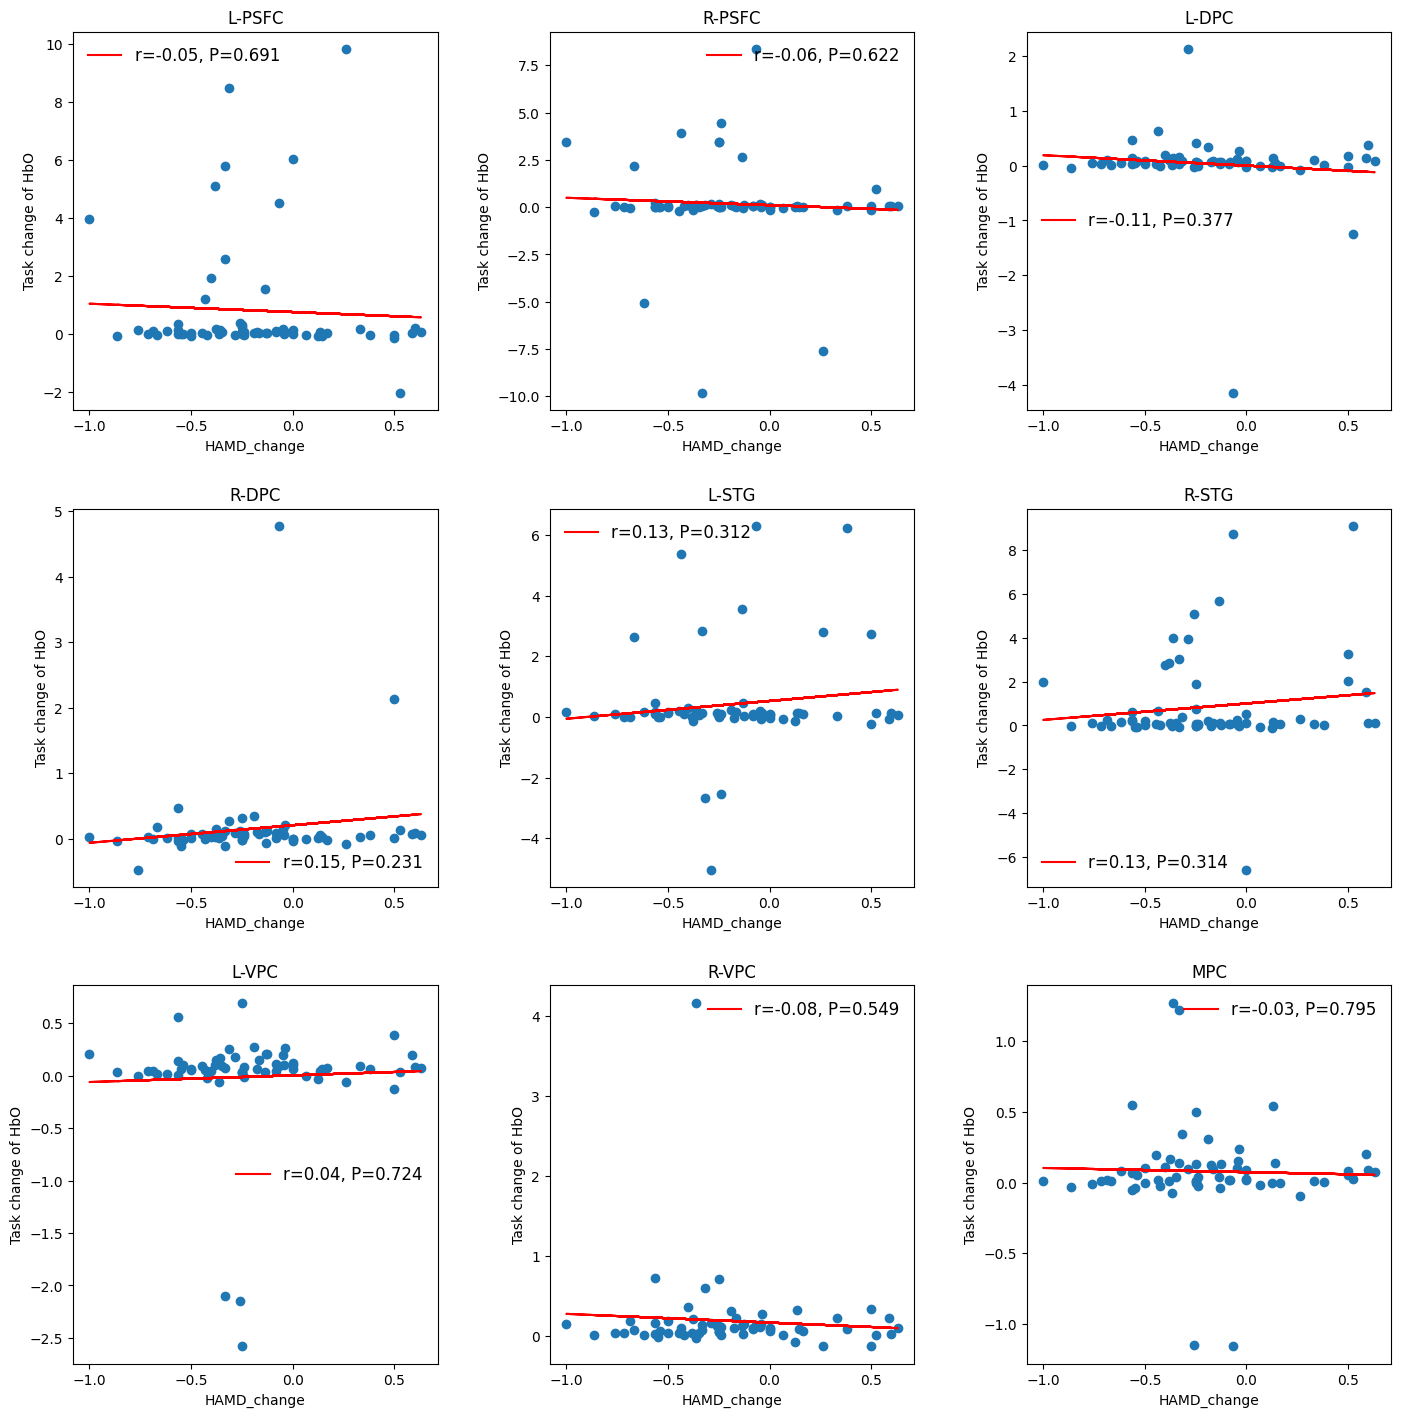

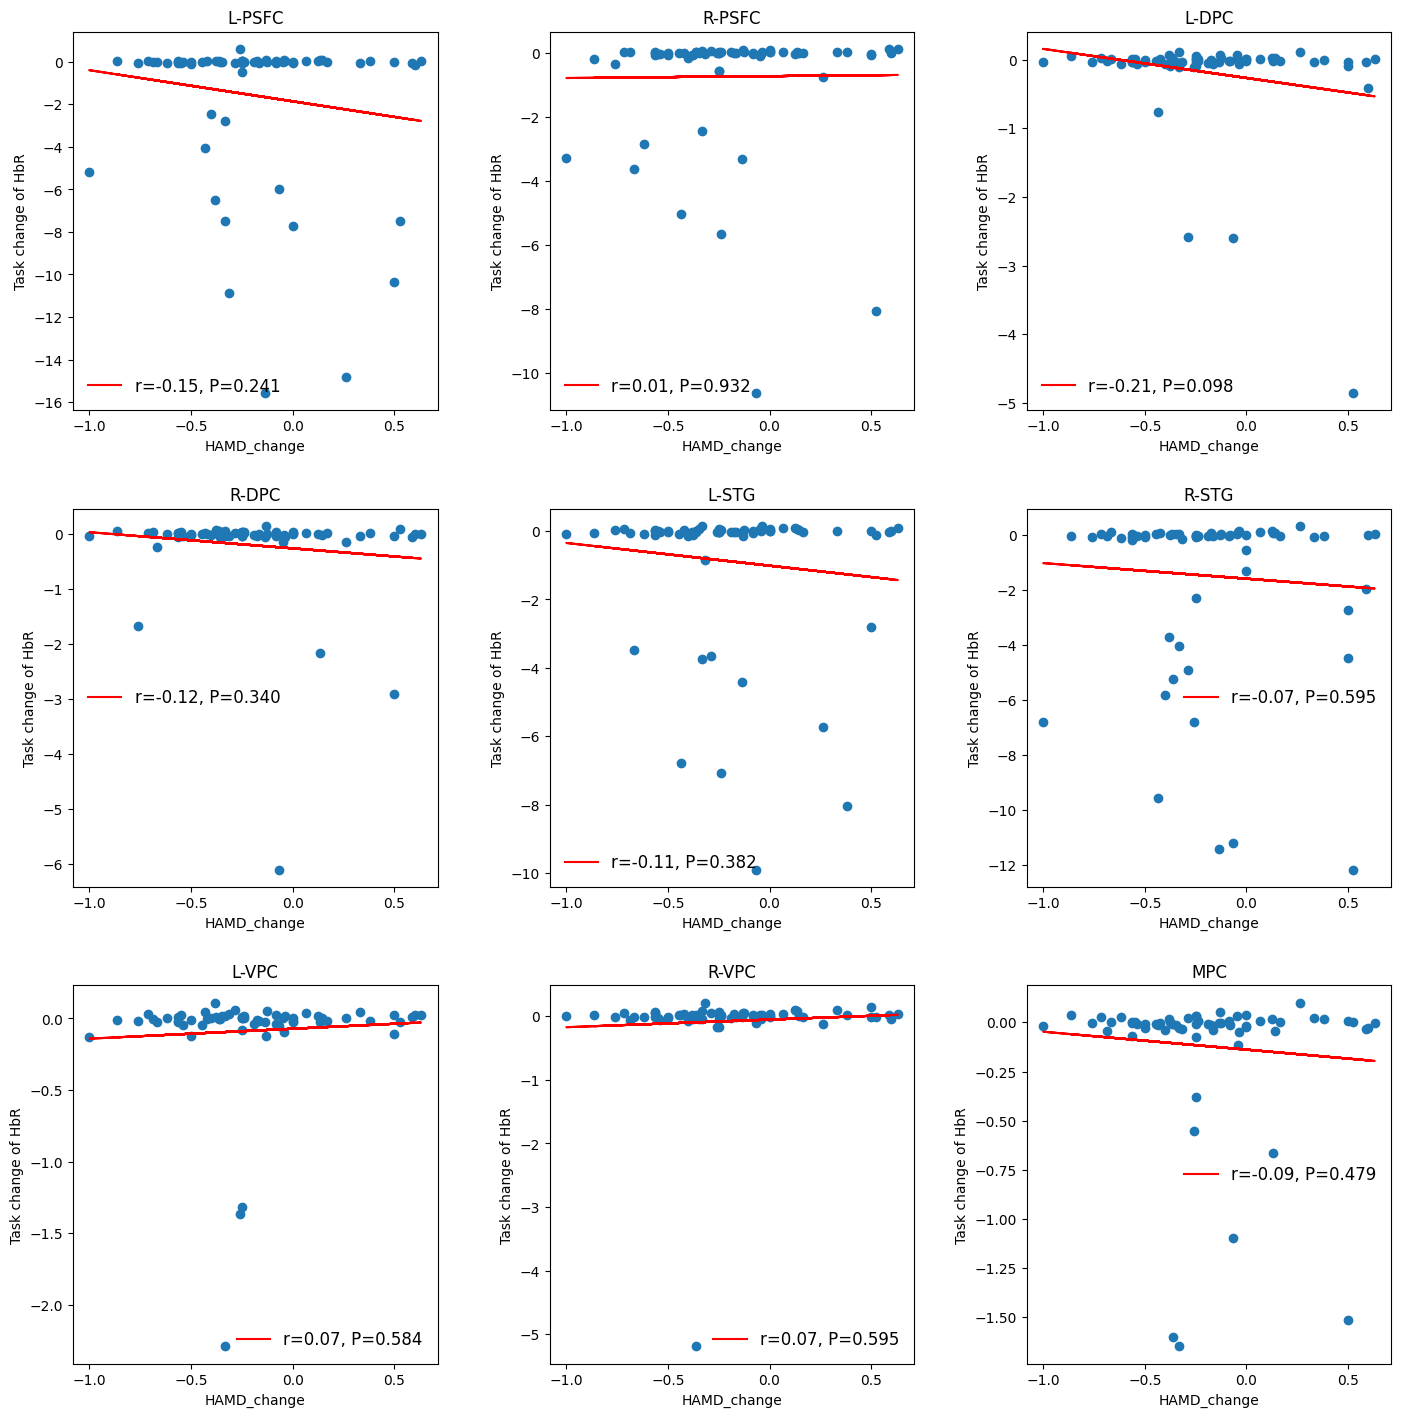

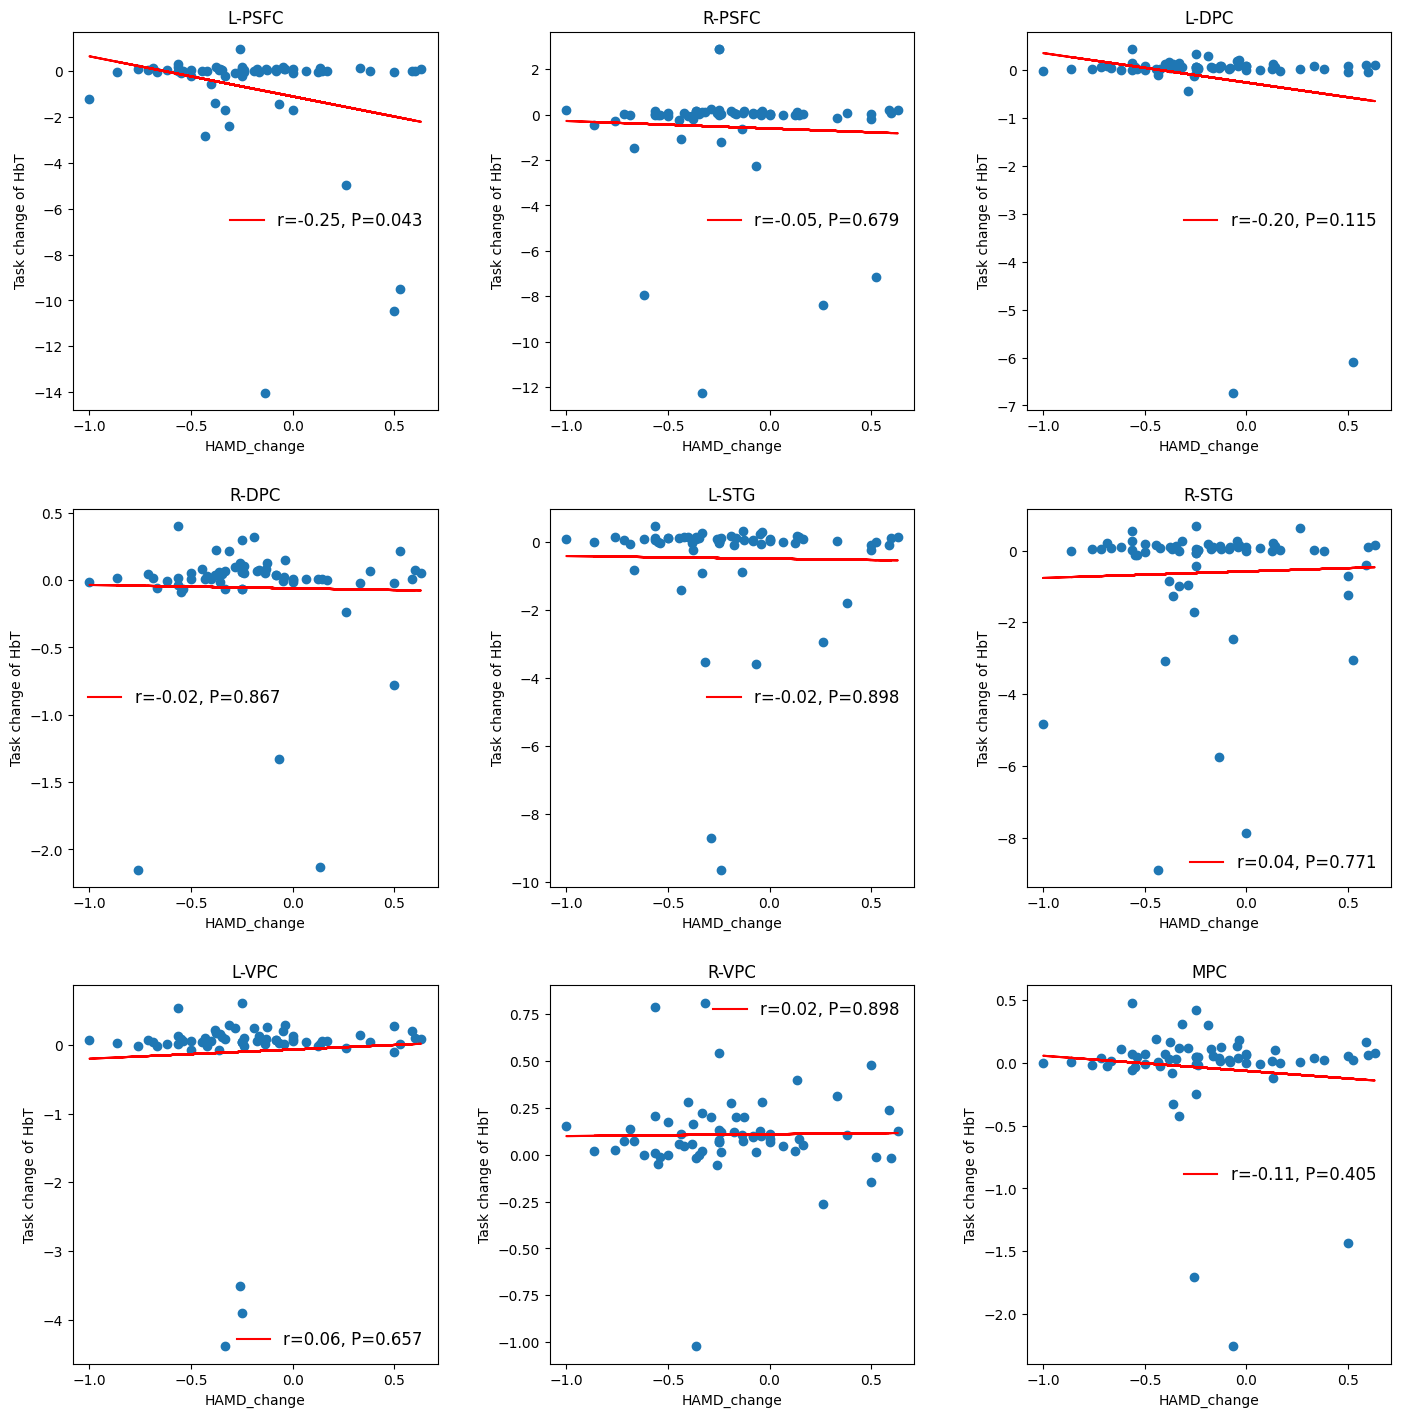

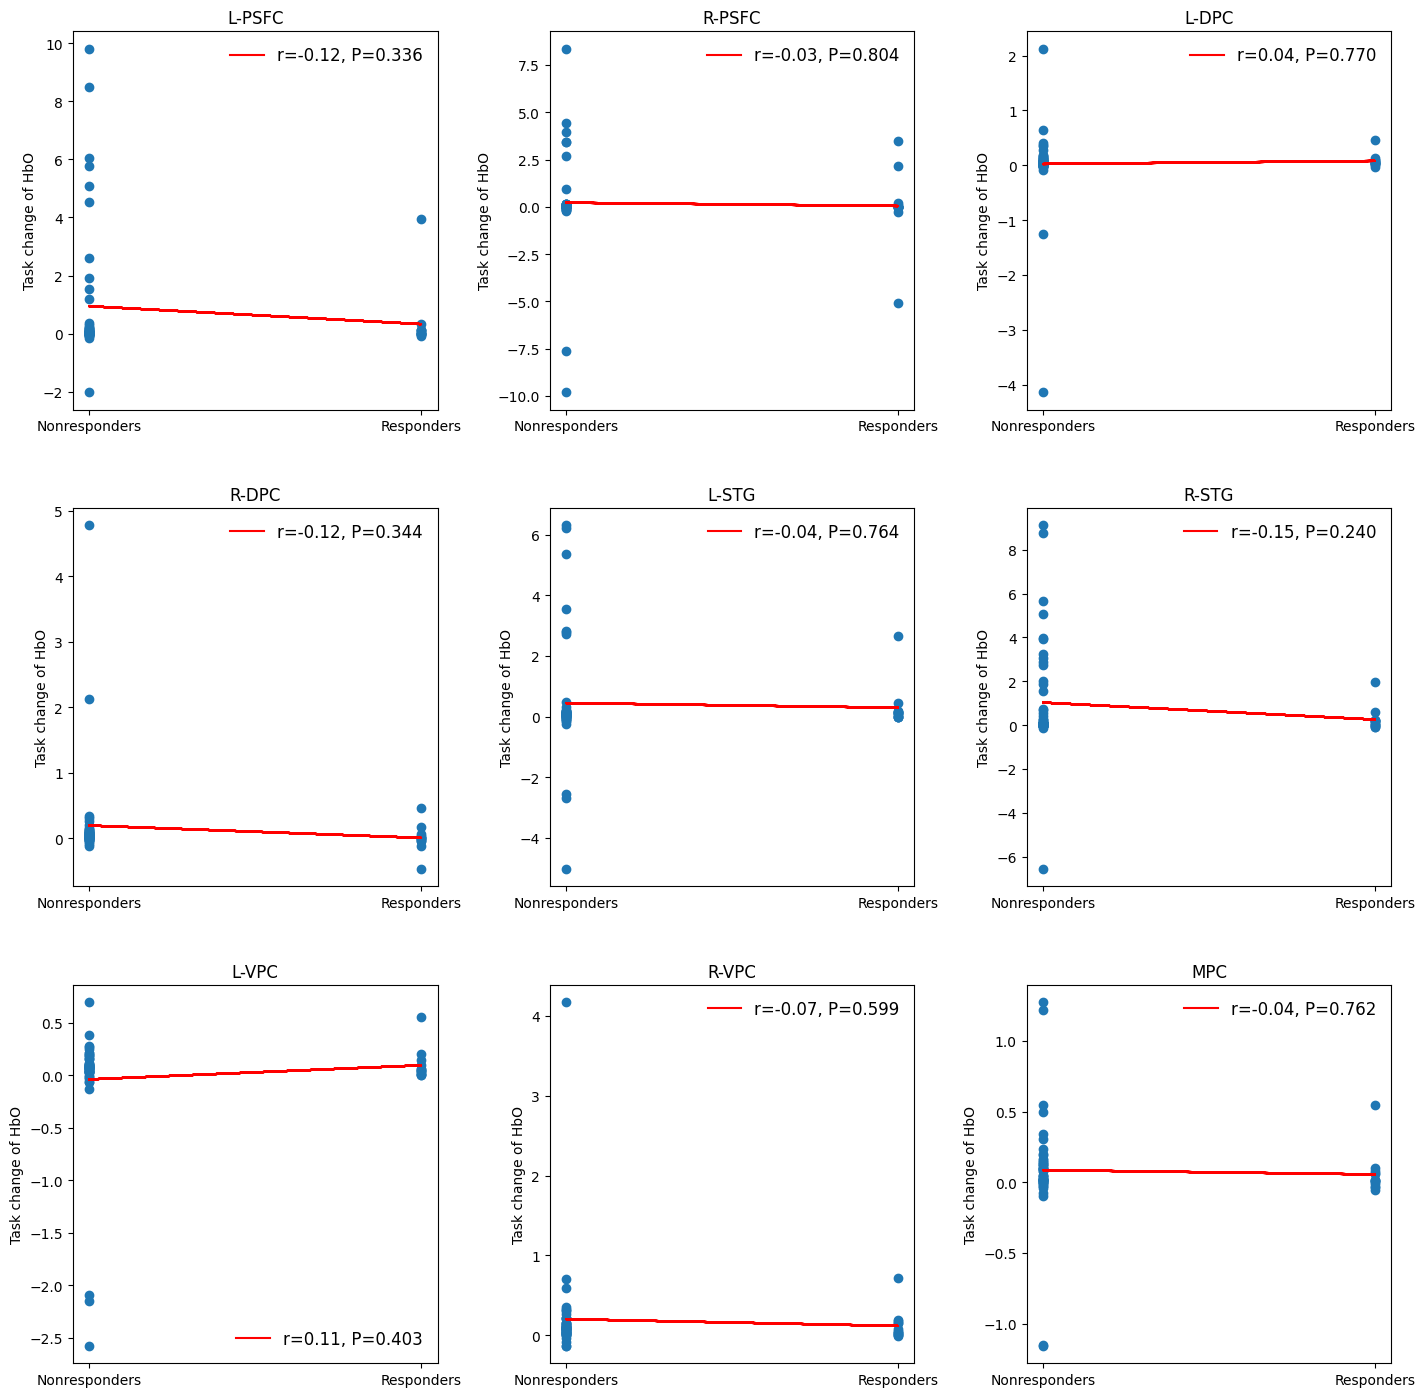

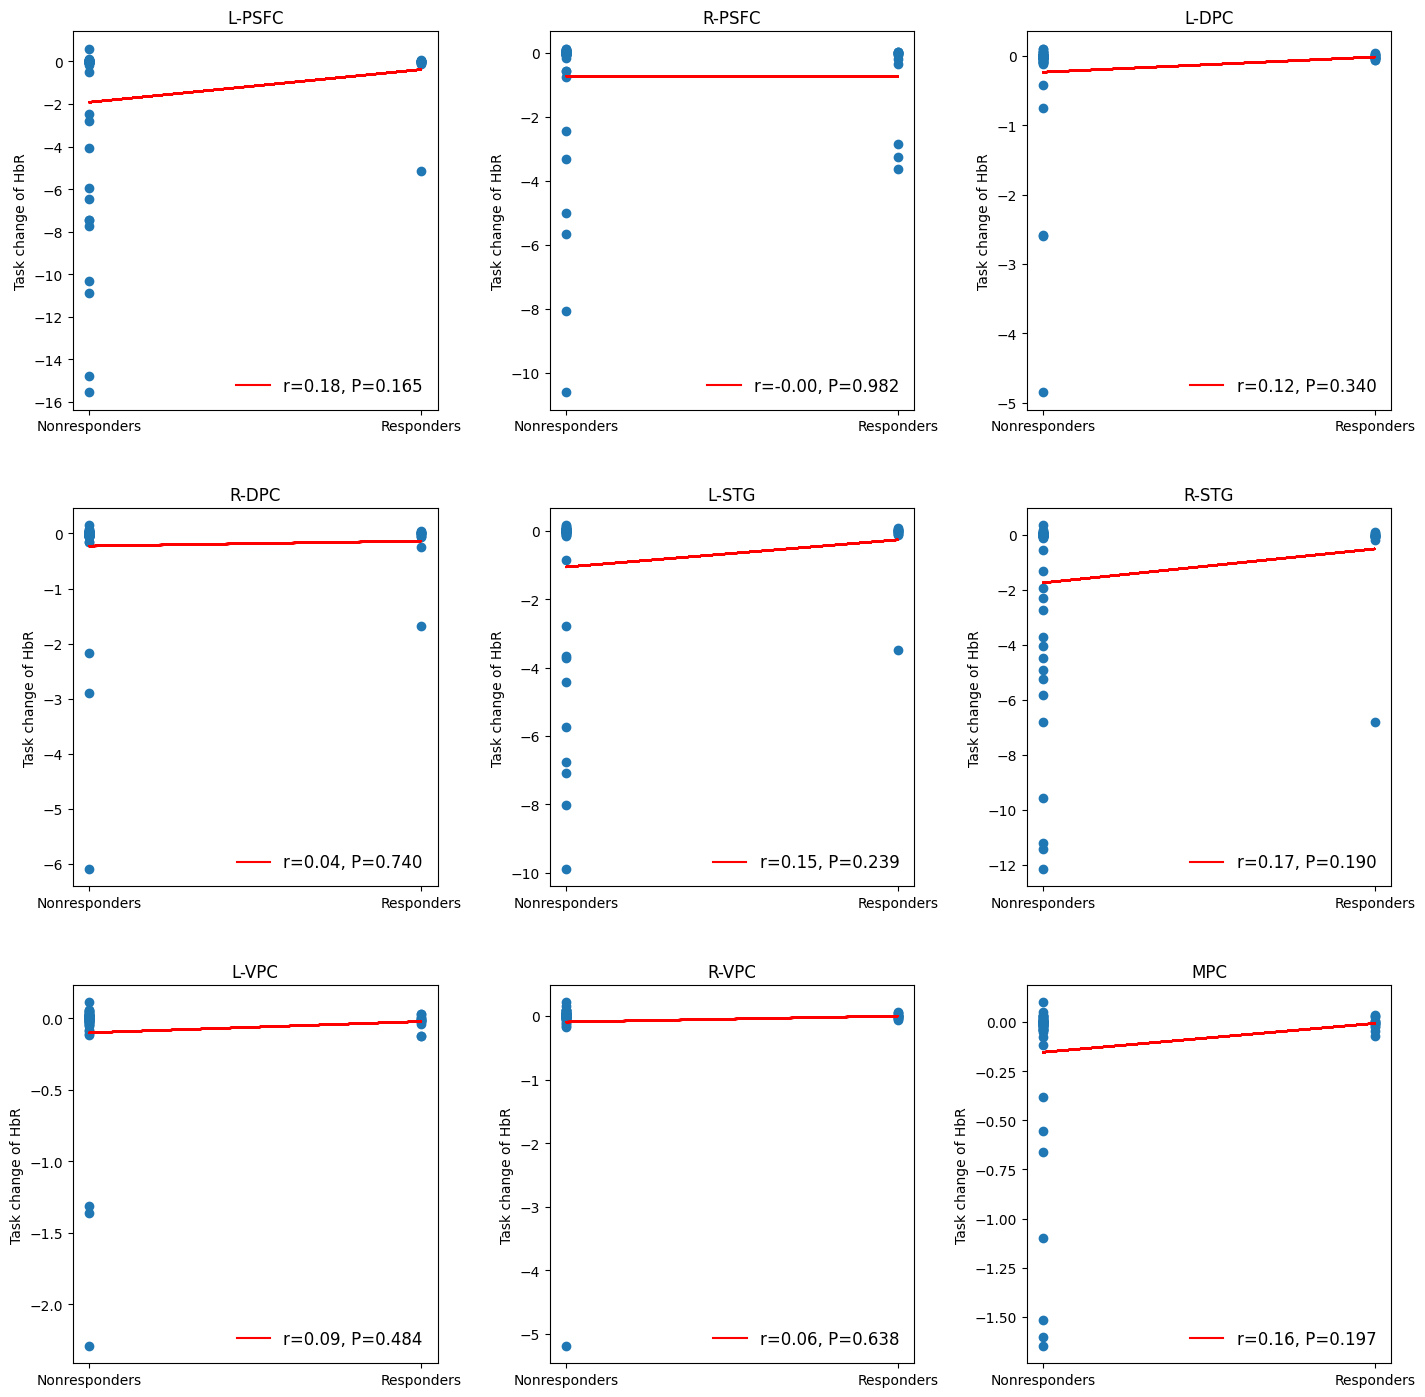

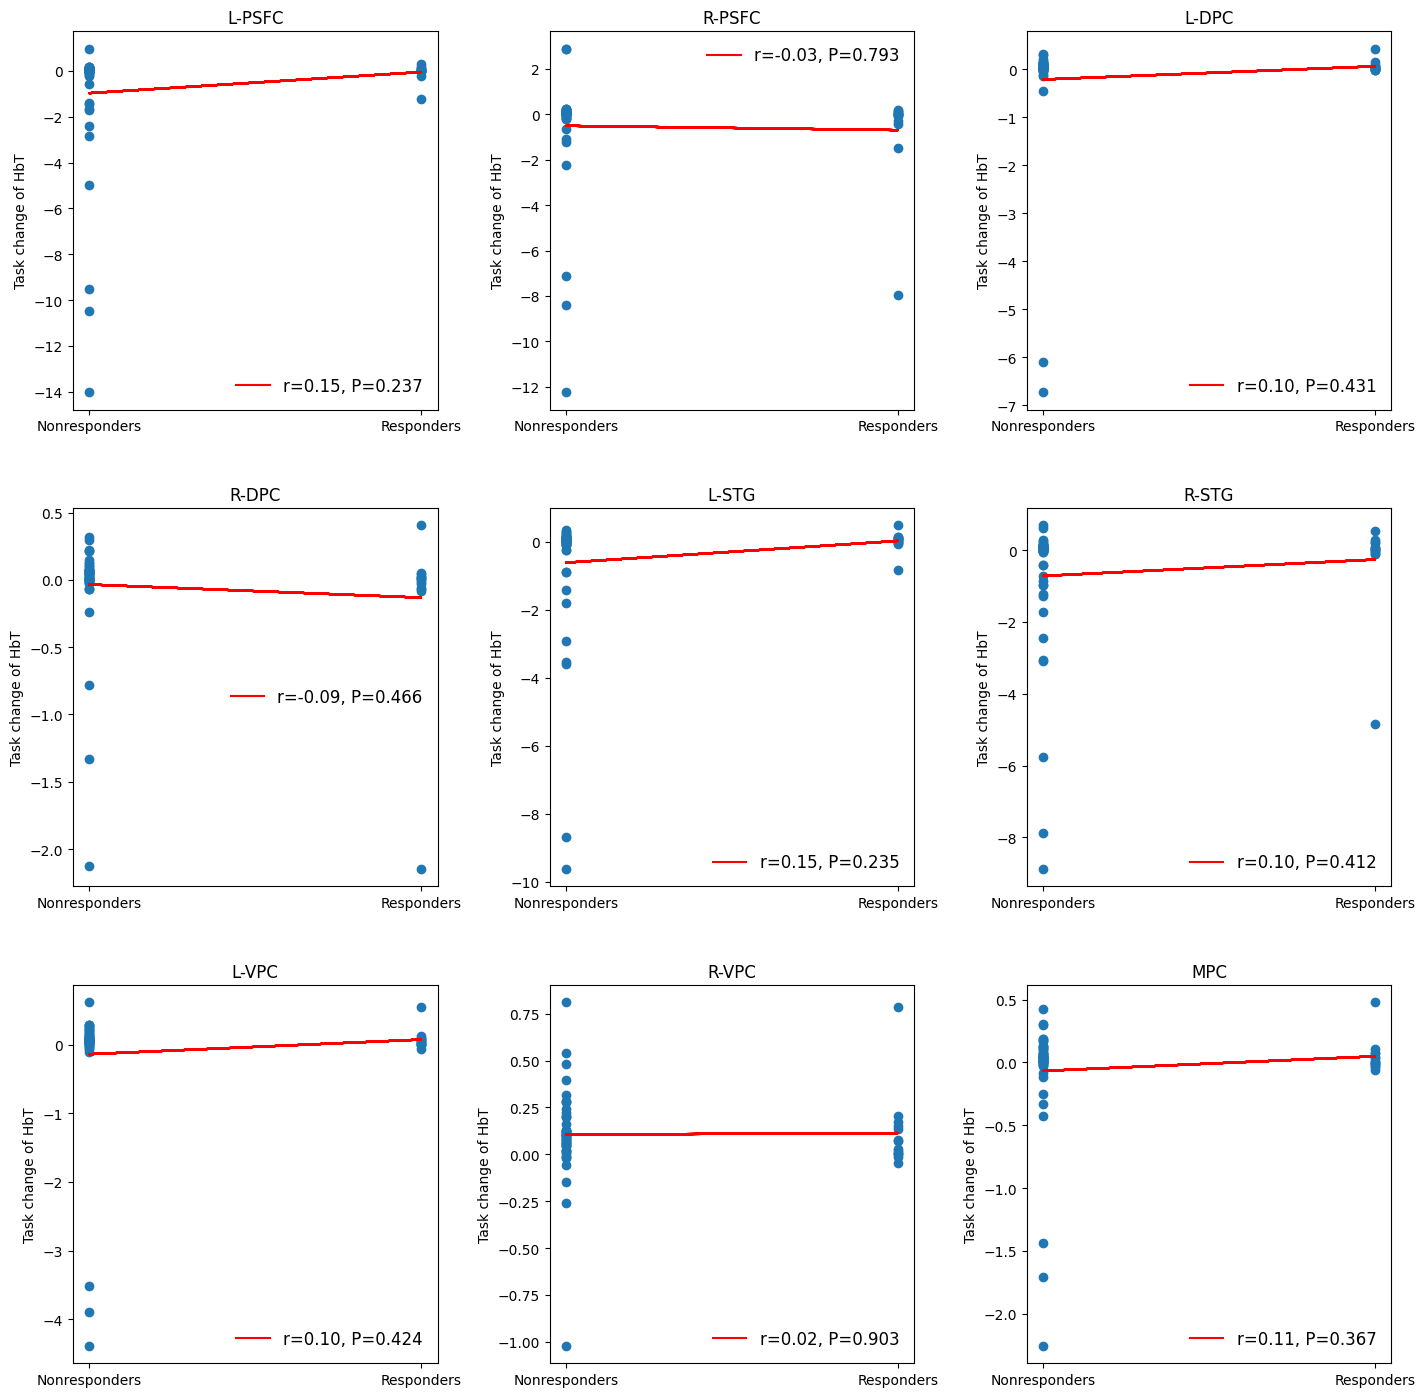

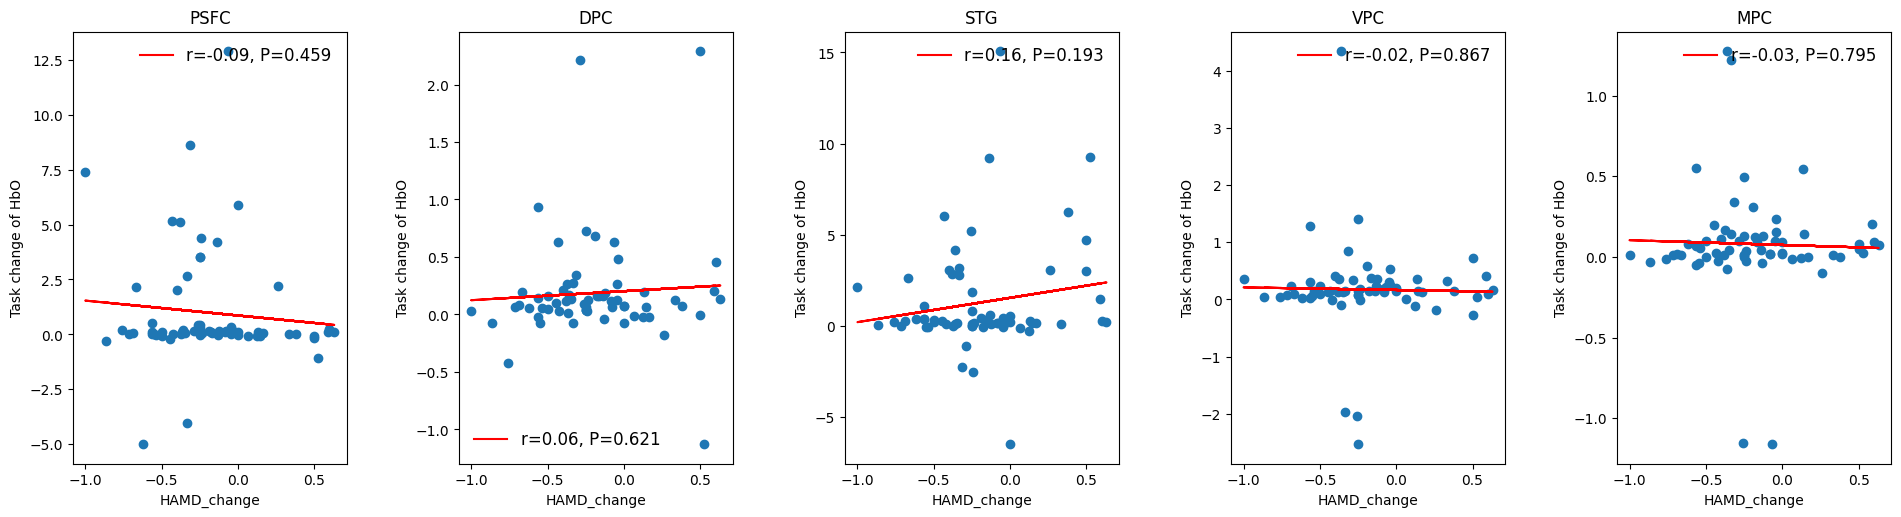

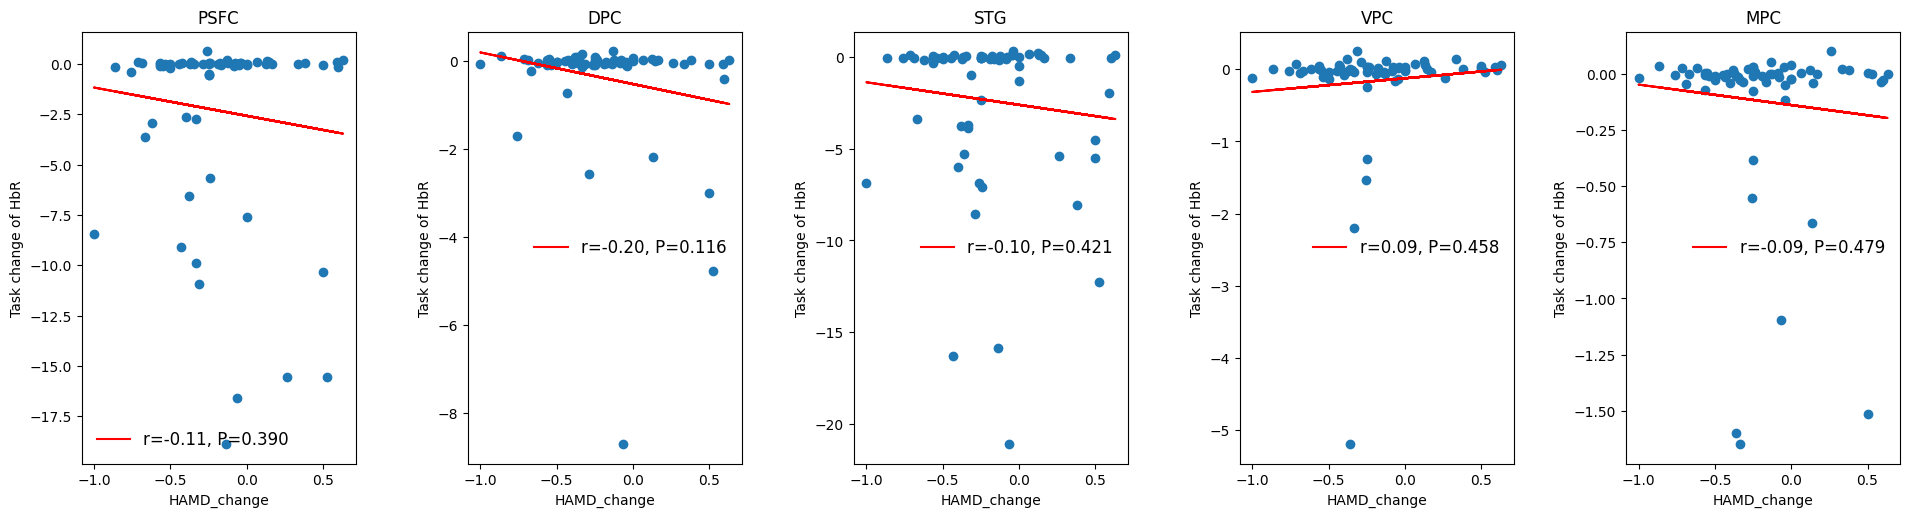

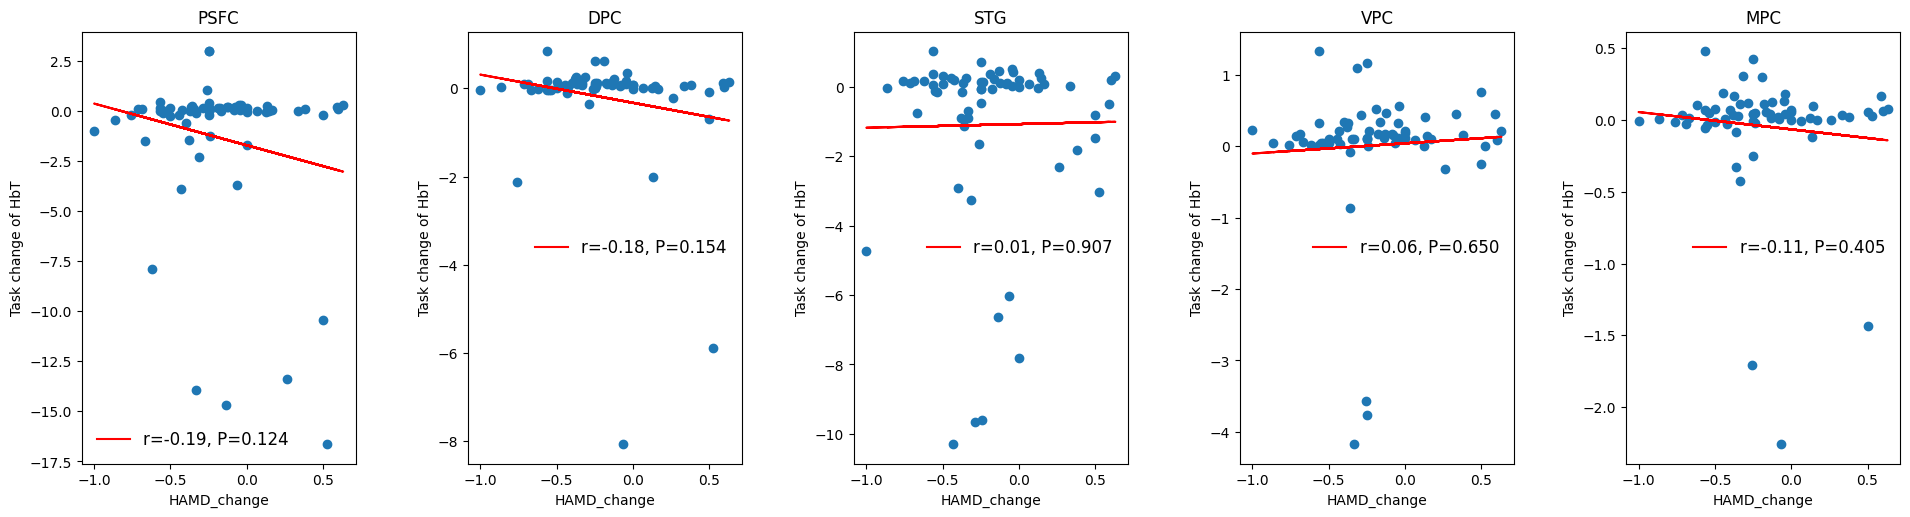

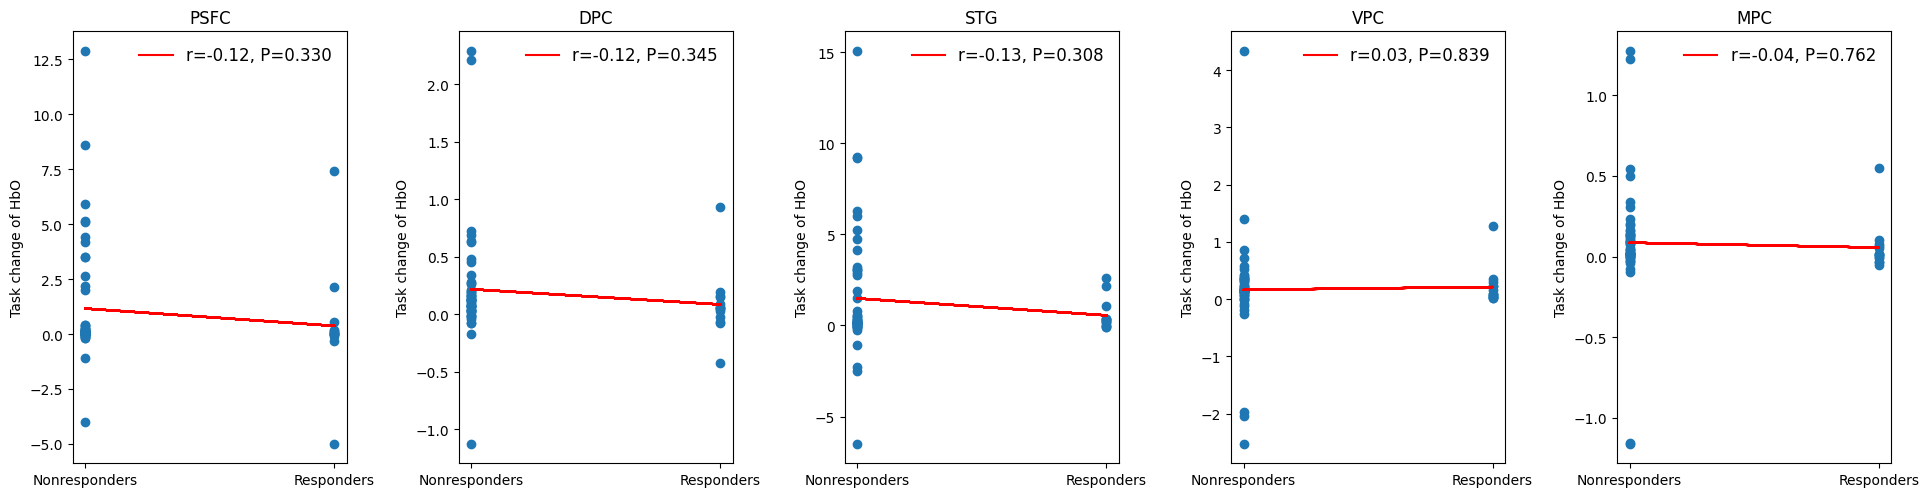

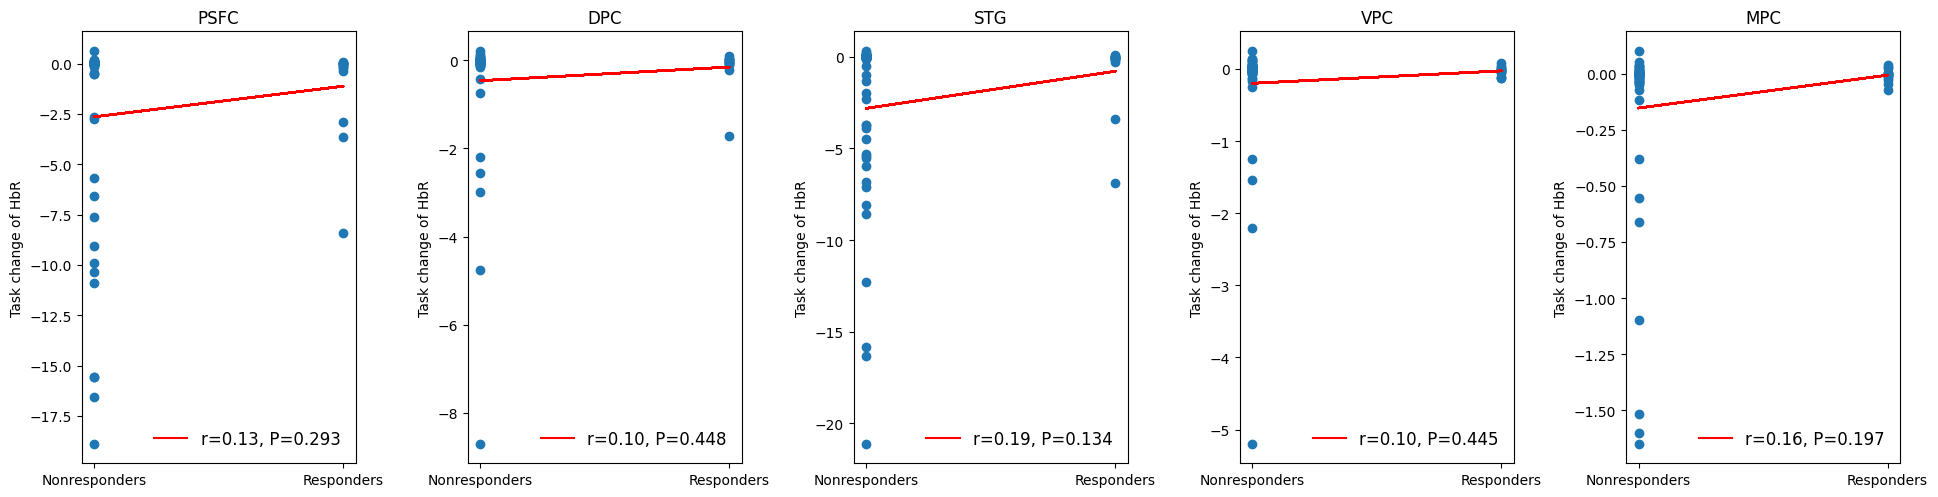

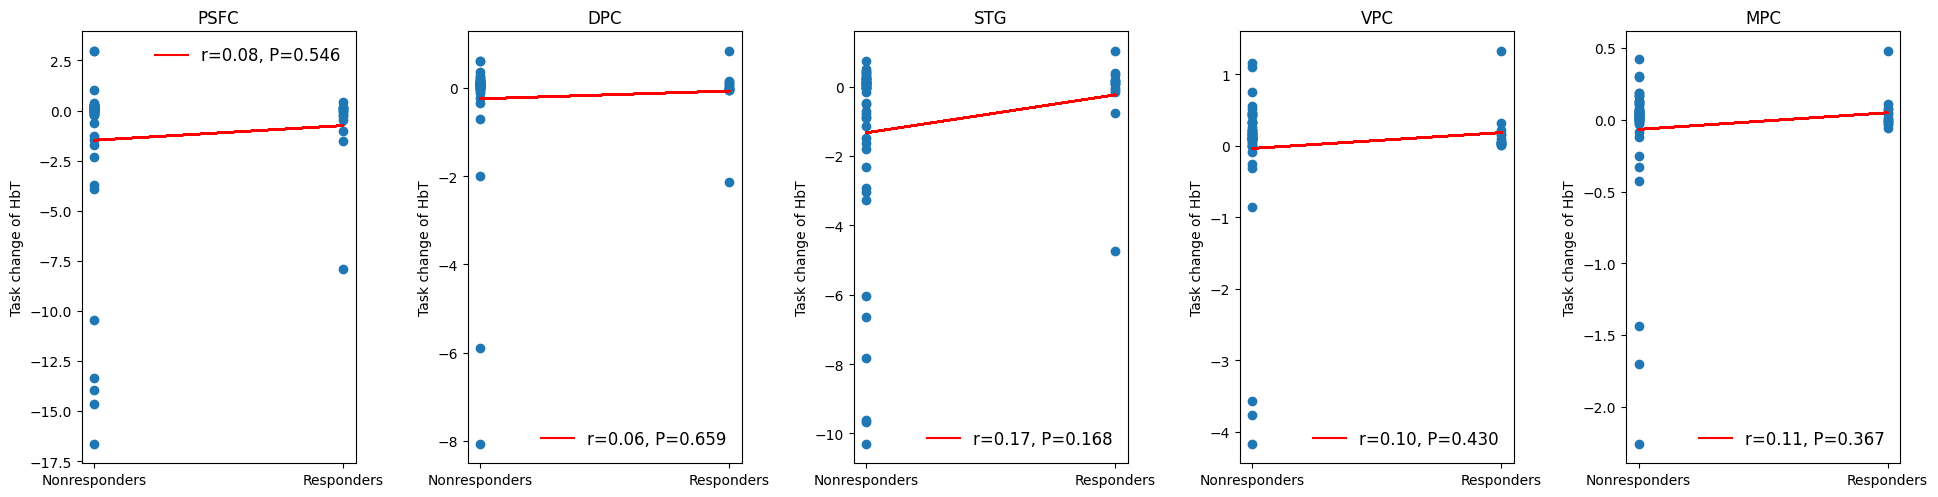

In [113]:


import matplotlib.pyplot as plt

from chord import Chord
# load 
import sys
import time

from sklearn.model_selection import cross_val_score,train_test_split
from datetime import date
import numpy as np
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
import pingouin as pg
import subprocess
import os 
from scipy.stats import ranksums
from scipy.stats import pearsonr
from scipy import stats


if sys.platform == 'darwin':
    print("Current system is macOS")
    main_fold_path = '/Users/shanxiafeng/Documents/Project/Research/fnirs-prognosis/code/fnirs-treatment-response-prediction'
elif sys.platform == 'linux':
    print("Current system is Ubuntu")
    main_fold_path = '/home/jy/Documents/fnirs/treatment_response/fnirs-depression-deeplearning'
else:
    print("Current system is neither macOS nor Ubuntu")
    
    
os.chdir(main_fold_path)


from utils.fnirs_utils import get_nine_region_data


    
DATA =  np.load('allData/prognosis_mix_hb/pretreatment_response/hb_data.npy')
LABEL =  np.load('allData/prognosis_mix_hb/pretreatment_response/label.npy')
data = DATA
label = LABEL
data = get_nine_region_data(data)

x = np.load('allData/prognosis_mix_hb/pretreatment_response/label_hamd.npy')
reduced_percentage = (x[:, 1] - x[:, 0]) / x[:, 0]

HbO = np.transpose(data[...,0::2],(0,2,1))
# HbO = individual_normalization(HbO)
print(f'HbO: {HbO.shape}')
HbR = np.transpose(data[...,1::2],(0,2,1))
HbT = HbO + HbR

def set_xlabel_of_ax(ax, label_name):
    if label_name == 'HAMD_change':
        ax.set_xlabel(label_name)
        ax.set_xticks(np.arange(-1,1, 0.5))
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['Nonresponders', 'Responders'])
            
def get_five_regions_from_nine(data):
    res = np.zeros((data.shape[0], 5))
    res[:, 0] = data[:, 0] + data[:, 1]
    res[:, 1] = data[:, 2] + data[:, 3]
    res[:, 2] = data[:, 4] + data[:, 5]
    res[:, 3] = data[:, 6] + data[:, 7]
    res[:, 4] = data[:, 8]
    return res 

task_end_index = 700
task_start_index = 100
nine_region_name = ['L-PSFC', 'R-PSFC', 'L-DPC', 'R-DPC', 'L-STG', 'R-STG', 'L-VPC', 'R-VPC', 'MPC']
five_region_name = ['PSFC', 'DPC', 'STG', 'VPC', 'MPC']

dict_hb = {'HbO': HbO, 'HbR': HbR, 'HbT': HbT}

dict_label = {'HAMD_change': reduced_percentage, 'Responders': label}

dict_region = {'nine_regions': nine_region_name, 'five_regions': five_region_name}

feature_name_all = ['task_change', 'mean', 'task_activation']

HB = HbT
hb_type = 'HbT'

region_num = 'nine_regions'

output_fold = 'FigureTable/regression'

for feature_name in feature_name_all:

    for region_num, region_name in dict_region.items():
        for label_name, label_val in dict_label.items():
            
            for hb_type, HB in dict_hb.items():
                task_change_hb = np.zeros((64, 1, 9))
                
                for i in range(task_change_hb.shape[-1]):
                    if feature_name == 'task_change': x = HB[:, task_end_index:, i].mean(axis=1) - HB[:, :task_start_index, i].mean(axis=1)
                    if feature_name == 'mean': x = HB[:, :, i].mean(axis=1) 
                    if feature_name == 'task_activation': x = HB[:, task_start_index:task_end_index, i].mean(axis=1) - HB[:, :task_start_index, i].mean(axis=1) - HB[:, task_end_index:, i].mean(axis=1)
                    
                    x = x[:, np.newaxis]
                    task_change_hb[:, :, i] = x

                task_change_hb = task_change_hb.squeeze()
                
                if region_num=='five_regions': 
                    task_change_hb = get_five_regions_from_nine(task_change_hb)
                    fig, axs = plt.subplots(1, 5, figsize=(20, 6))
                else:
                    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
                fig.tight_layout(pad=5.0)
                signifance_flag = False 
                for i in range(task_change_hb.shape[-1]):
                    if region_num=='five_regions': 
                        ax = axs[i]
                    else:
                        ax = axs[i // 3, i % 3]
                    region_task_change = task_change_hb[:, i]
                    
                    # Calculate correlation coefficient and p-value
                    correlation_coefficient, p_value = pearsonr(label_val, region_task_change)
                    
                    # Fit a line to the data
                    fit_line = np.polyfit(label_val, region_task_change, 1)
                    
                    # Evaluate the fit line at each data point
                    fit_line_values = np.polyval(fit_line, label_val)
                    
                    # Create a new figure
                    ax.scatter(label_val, region_task_change)
                    ax.plot(label_val, fit_line_values, color='red', label=f'r={correlation_coefficient:.2f}, P={p_value:.3f}')
                    if signifance_flag == False:
                        signifance_flag = True if p_value < 0.05 else False
                    set_xlabel_of_ax(ax, label_name)

                    ax.set_ylabel(f"Task change of {hb_type}")
                    ax.set_title(region_name[i])
                    ax.legend(frameon=False, fontsize=12)
            


                output_fold_final = output_fold + '/all/' + f'{label_name}/{region_num}'
                if not os.path.exists(output_fold_final):
                        os.makedirs(output_fold_final)
                plt.savefig(output_fold_final + f'/{feature_name}_{hb_type}_{region_num}.png')
                
                if signifance_flag:
                    output_fold_final = output_fold + '/significance/' + f'{label_name}/{region_num}'
                    if not os.path.exists(output_fold_final):
                            os.makedirs(output_fold_final)
                    plt.savefig(output_fold_final + f'/{feature_name}_{hb_type}_{region_num}.png')